In [1]:
import sys
import os
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
import netCDF4 as nc
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D, seed_everything
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
import pickle
from sklearn.utils import class_weight
from os import listdir
from os.path import isfile, join
import time
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import matplotlib.pyplot as plt
from keras import backend as K
import scipy.io as scio
from scipy import stats
from echo.src.base_objective import BaseObjective
from echo.src.pruners import KerasPruningCallback
sys.path.append('/glade/work/fanda/optimization/echo_opt')
sys.path.append('/glade/work/fanda/util/goes16ci/goes16ci')
#from models_test import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
import optuna
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

2022-08-14 20:08:48.679404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.
2022-08-14 20:08:59.858094: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 20:08:59.859207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-14 20:08:59.868271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-14 20:08:59.868295: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-14 20:08:59.875123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-14 20:08:59.875198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic l

In [ ]:
print(processed_file.variables['lat_0'])

In [40]:
delete_row

[1122, 1856, 3281]

In [ ]:
print(processed_file.variables['label'])

In [ ]:
a=0
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(My_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
    a=a+len(train)
    print(np.shape(train))

In [49]:
np.random.permutation(len(all_images))

array([14801, 20054,  7143, ...,  9194,  5328, 20451])

In [2]:
#def main():
seed_everything(4835)
My_dir = '/glade/scratch/fanda/files/GOESR_HRRR_PC/'#GOESR_HRRR_PC/'
test_dir = My_dir+'test/'
onlyfiles = [f for f in listdir(My_dir) if isfile(join(My_dir, f))]
testfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]

config_file = open('/glade/work/fanda/optimization/benchmark_config_default_echo_best.yml',"r")
config = yaml.load(config_file, Loader=yaml.Loader)
print(config["dtype"])
# load data serial
logging.info("Split training and validation data")
train = []
label = []
test = []
test_label = []
lat_1 = []
lon_1 = []
date_1 = []
Type_1 = []
benchmark_data = dict()
# load data serial
benchmark_data["config"] = config
for file in onlyfiles:
    processed_file = nc.Dataset(os.path.join(My_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    train.append(processed_file.variables['predictor'])
    label.append(processed_file.variables['label'])
all_images = np.concatenate(train).astype(config["dtype"])
all_labels = np.concatenate(label).astype(config["dtype"])
all_images = np.moveaxis(all_images,1,-1)
delete_row =[]
for i in range(len(all_labels)):
    if np.sum(np.isnan(all_images[i,:,:,:]))>0:
        delete_row.append(i)
all_images = np.delete(all_images, delete_row, 0)
all_labels = np.delete(all_labels, delete_row, 0)
delete_row =[]
for file in testfiles:
    processed_file = nc.Dataset(os.path.join(test_dir,file))
    #if np.sum(np.isnan(processed_file.variables['predictor']))==0:
    test.append(processed_file.variables['predictor'])
    test_label.append(processed_file.variables['label'])
    lat_1.append(processed_file.variables['lat_0'])
    lon_1.append(processed_file.variables['lon_0'])
    date_1.append(processed_file.variables['date'])
    Type_1.append(processed_file.variables['Type'])
test_images = np.concatenate(test).astype(config["dtype"])
test_labels = np.concatenate(test_label).astype(config["dtype"])
lat_0 = np.concatenate(lat_1).astype(config["dtype"])
lon_0 = np.concatenate(lon_1).astype(config["dtype"])
date_0 = np.concatenate(date_1).astype(config["dtype"])
Type_0 = np.concatenate(Type_1).astype(config["dtype"])
test_images = np.moveaxis(test_images,1,-1)
for i in range(len(test_labels)):
    if np.sum(np.isnan(test_images[i,:,:,:]))>0:
        delete_row.append(i)
test_images = np.delete(test_images, delete_row, 0)
test_labels = np.delete(test_labels, delete_row, 0)
lat_0= np.delete(lat_0, delete_row, 0)
lon_0= np.delete(lon_0, delete_row, 0)
date_0= np.delete(date_0, delete_row, 0)
Type_0= np.delete(Type_0, delete_row, 0)
print(np.shape(all_images))
print(np.shape(test_images))
num = np.shape(all_images)[0]
shuffler = np.random.permutation(len(all_images))
images_shuffled = all_images[shuffler]
labels_shuffled = all_labels[shuffler]
shuffler2 = np.random.permutation(len(test_images))
test_images_shuffled = test_images[shuffler2]
test_labels_shuffled = test_labels[shuffler2]
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]
date_0 = date_0[shuffler2]
Type_0 = Type_0[shuffler2]

train_val_split = 40000#25000
num_ch = np.arange(7,14)#28,35)
train_data = images_shuffled[:train_val_split,:,:,num_ch].astype(config["dtype"])
train_label = labels_shuffled[:train_val_split].astype(config["dtype"])
val_data = images_shuffled[train_val_split:,:,:,num_ch].astype(config["dtype"])
val_label = labels_shuffled[train_val_split:].astype(config["dtype"])
test_data = test_images_shuffled[:,:,:,num_ch].astype(config["dtype"])
test_label = test_labels_shuffled[:].astype(config["dtype"])
#print("ALL DATA=", all_data)

#rotate 90/180/270/360 degree
'''
for i in range(len(train_data)):
    train_data[i,:,:,:]=tf.image.rot90(train_data[i,:,:,:], k=np.random.randint(0,4))
for i in range(len(test_data)):
    test_data[i,:,:,:]=tf.image.rot90(test_data[i,:,:,:], k=np.random.randint(0,4))
'''
scaler = MinMaxScaler2D()
train_data_scaled = 1.0 - scaler.fit_transform(train_data) #1.0 - train_data#1.0 - scaler.fit_transform(train_data)
val_data_scaled = 1.0 - scaler.transform(val_data) #1.0 -val_data#1.0 - scaler.transform(val_data)
test_data_scaled = 1.0 - scaler.transform(test_data)
print(np.shape(train_data))
print(np.shape(test_data))
#for i in range(num_ch):
#    for j in range(num):
#        all_images[j,:,:,i] = (all_images[j,:,:,i] - np.min(np.squeeze(all_images[j,:,:,i])))\
#        /(np.max(np.squeeze(all_images[j,:,:,i]))-np.min(np.squeeze(all_images[j,:,:,i])))
#train_val_split = 28000 #1300 #14000

float32
(56647, 32, 32, 57)
(13747, 32, 32, 57)
(40000, 32, 32, 7)
(13747, 32, 32, 7)


In [ ]:
print(np.shape(lat_0))
print(np.shape(test_labels))

In [ ]:
lat_0 = lat_0[shuffler2]
lon_0 = lon_0[shuffler2]

In [ ]:
print(np.shape(test_labels))

In [3]:
train_label_one_hot = tf.one_hot(train_label, 2).numpy()
val_label_one_hot = tf.one_hot(val_label, 2).numpy()
test_label_one_hot = tf.one_hot(test_label, 2).numpy()

2022-08-14 20:10:33.707164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-14 20:10:33.707634: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-14 20:10:33.708296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-14 20:10:33.708335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-14 20:10:33.708401: I tensorflow/stream_executor/platform/default/dso_loader.cc:49]

In [5]:
from tensorflow.keras.callbacks import Callback
def KL(alpha):
    num_classes = 2
    #print(alpha.shape)
    one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
    S = K.sum(alpha,axis=1,keepdims=True)

    kl = tf.math.lgamma(S) - K.sum(tf.math.lgamma(alpha),axis=1,keepdims=True) +\
    K.sum(tf.math.lgamma(one),axis=1,keepdims=True) - tf.math.lgamma(K.sum(one,axis=1,keepdims=True)) +\
    K.sum((alpha - one)*(tf.math.digamma(alpha)-tf.math.digamma(S)),axis=1,keepdims=True)

    return kl

def loss_func_CE(y_true, output):
    annealing_step = 2 *(25000 // 564)
    #Eqn 4: cross-entropy loss
    y_evidence = K.relu(output)
    alpha = y_evidence+1
    S = K.sum(alpha,axis=1,keepdims=True)
    A = K.sum(y_true * (tf.math.digamma(S) - tf.math.digamma(alpha)), axis=1, keepdims=True)
    A = K.sum(A)

    #print(self.current_epoch_num)
    #kl = K.sum(self.KL((1-y_true)*(alpha)+y_true))
    #print(TimeHistory().epoch_step)
    kl =  K.minimum(1.0, TimeHistory().epoch_step/annealing_step) * K.sum(KL((1-y_true)*(alpha)+y_true))
    return A + kl

def loss_func_CE_custom(outputs, y_true, epoch):
    output=outputs[:,:2]
    annealing_step = 2 *(25000 // 564)
    #Eqn 4: cross-entropy loss
    y_evidence = K.relu(output)
    alpha = y_evidence+1
    S = K.sum(alpha,axis=1,keepdims=True)
    A = K.sum(y_true * (tf.math.digamma(S) - tf.math.digamma(alpha)), axis=1, keepdims=True)
    A = K.sum(A)

    #print(self.current_epoch_num)
    #kl = K.sum(self.KL((1-y_true)*(alpha)+y_true))
    #print(TimeHistory().epoch_step)
    kl =  K.minimum(1.0, epoch/annealing_step) * K.sum(KL((1-y_true)*(alpha)+y_true))
    return A + kl

class TimeHistory(Callback):
    def __init__(self):
        self.times = []
        self.epoch_step = 0
        self.epoch_time_start = 0
        super(TimeHistory, self).__init__()

    def on_train_begin(self, logs=None):
        self.times = []
        self.epoch_step = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = perf_counter()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_step += 1
        print(self.epoch_step)
        self.times.append(perf_counter() - self.epoch_time_start)
        
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        print(logs)
        self.val_losses.append(logs.get("val_loss"))
        
def var(name, shape, init=None):
    init = tf.compat.v1.truncated_normal_initializer(stddev=(1 / shape[0]) ** 0.5) if init is None else init
    return tf.compat.v1.get_variable(name=name, shape=shape, dtype=tf.float32, initializer=init)

def DEAL_dense_layer(x, units, scope='DEAL_dense_0'):
    with tf.compat.v1.variable_scope(scope):
        print(x.get_shape())
        W3 = var('W3', [x.get_shape()[1], 1000])
        b3 = var('b3', [1000])
        out3 = tf.nn.relu(tf.matmul(x, W3) + b3)

        print('OUT3')
        print(out3.shape)

        W4 = var('W4', [1000, units])
        b4 = var('b4', [units])
        logits = tf.matmul(out3, W4) + b4
        return logits
import random
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

def get_kernel_divergence_fn(train_size, w=1.0):
    """
    Get the kernel Kullback-Leibler divergence function
    # Arguments
        train_size (int): size of the training dataset for normalization
        w (float): weight to the function
    # Returns
        kernel_divergence_fn: kernel Kullback-Leibler divergence function
    """
    def kernel_divergence_fn(q, p, _):  # need the third ignorable argument
        kernel_divergence = tfp.distributions.kl_divergence(q, p) / tf.cast(train_size, tf.float32)
        return w * kernel_divergence
    return kernel_divergence_fn


def get_kernel_posterior_fn(kernel_posterior_scale_mean=-9.0,
                            kernel_posterior_scale_stddev=0.1,
                            kernel_posterior_scale_constraint=0.2):
    """
    Get the kernel posterior distribution
    # Arguments
        kernel_posterior_scale_mean (float): kernel posterior's scale mean.
        kernel_posterior_scale_stddev (float): the initial kernel posterior's scale stddev.
          ```
          q(W|x) ~ N(mu, var),
          log_var ~ N(kernel_posterior_scale_mean, kernel_posterior_scale_stddev)
          ````
        kernel_posterior_scale_constraint (float): the log value to constrain the log variance throughout training.
          i.e. log_var <= log(kernel_posterior_scale_constraint).
    # Returns
        kernel_posterior_fn: kernel posterior distribution
    """

    def _untransformed_scale_constraint(t):
        return tf.clip_by_value(t, -1000, tf.math.log(kernel_posterior_scale_constraint))

    kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(
        untransformed_scale_initializer=tf.random_normal_initializer(
            mean=kernel_posterior_scale_mean,
            stddev=kernel_posterior_scale_stddev),
        untransformed_scale_constraint=_untransformed_scale_constraint)
    return kernel_posterior_fn

def get_neg_log_likelihood_fn(bayesian=True):
    """
    Get the negative log-likelihood function
    # Arguments
        bayesian(bool): Bayesian neural network (True) or point-estimate neural network (False)
    # Returns
        a negative log-likelihood function
    """
    if bayesian:
        def neg_log_likelihood_bayesian(y_true, y_pred):
            labels_distribution = tfp.distributions.Categorical(logits=y_pred)
            log_likelihood = labels_distribution.log_prob(tf.argmax(input=y_true, axis=1))
            loss = -tf.reduce_mean(input_tensor=log_likelihood)
            return loss
        return neg_log_likelihood_bayesian
    else:
        def neg_log_likelihood(y_true, y_pred):
            y_pred_softmax = keras.layers.Activation('softmax')(y_pred)  # logits to softmax
            loss = keras.losses.categorical_crossentropy(y_true, y_pred_softmax)
            return loss
        return neg_log_likelihood
    
def get_categorical_accuracy_fn(y_true, y_pred):
    y_pred_softmax = keras.layers.Activation('softmax')(y_pred)  # logits to softmax
    acc = keras.metrics.categorical_accuracy(y_true, y_pred_softmax)
    return acc

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.merge import concatenate
inputs = keras.Input(shape=(32, 32, 7), name="scn_input")
#First residual block

train_size = 270
def conv(n_filter, train_size, inputs):
    conv1 = tfp.layers.Convolution2DFlipout(n_filter, 3, padding="same",kernel_posterior_fn=get_kernel_posterior_fn(), kernel_divergence_fn=None, data_format="channels_last")
    w = conv1.add_weight(name=conv1.name+'/kl_loss_weight', shape=(), initializer=tf.initializers.constant(0.0), trainable=False)
    conv1.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w)
    return conv1(inputs)

x = conv(50, train_size, inputs)
y = layers.BatchNormalization(-1)(x)
y = layers.Activation("relu")(y)
y = conv(50, train_size, y)
y = layers.BatchNormalization(-1)(y)
y = layers.Activation("relu")(y)
y = conv(50, train_size, y)

x = layers.add([y,x])
x = layers.MaxPooling2D(data_format="channels_last")(x)
x = layers.Dropout(0.46772022583775175)(x, training=True)

#Second residual block
x = conv(100, train_size, x)
y = layers.BatchNormalization(-1)(x)
y = layers.Activation("relu")(y)
y = conv(100, train_size, y)
y = layers.BatchNormalization(-1)(y)
y = layers.Activation("relu")(y)
y = conv(100, train_size, y)

x = layers.add([y,x])
x = layers.MaxPooling2D(data_format="channels_last")(x)
x = layers.Dropout(0.46772022583775175)(x, training=True)

#Third residual block
x = conv(200, train_size, x)
y = layers.BatchNormalization(-1)(x)
y = layers.Activation("relu")(y)
y = conv(200, train_size, y)
y = layers.BatchNormalization(-1)(y)
y = layers.Activation("relu")(y)
y = conv(200, train_size, y)

x = layers.add([y,x])
x = layers.MaxPooling2D(data_format="channels_last")(x)
x = layers.Dropout(0.46772022583775175)(x, training=True)

x = layers.Flatten()(x)
x = layers.Dropout(0.46772022583775175)(x, training=True)

dense = tfp.layers.DenseFlipout(2,
                                activation=None,
                                kernel_posterior_fn=get_kernel_posterior_fn(),
                                kernel_divergence_fn=None)
w10 = dense.add_weight(name=dense.name+'/kl_loss_weight', shape=(), initializer=tf.initializers.constant(0.0), trainable=False)
dense.kernel_divergence_fn = get_kernel_divergence_fn(train_size, w10)
logits = dense(x)
'''
## For MC dropout
x = layers.Dense(2)(x)
x = layers.Dropout(0.026380573456759496)(x, training=True)
#logits = DEAL_dense_layer(x,units=2, scope="logits")
output = layers.Dense(2)(x)
log_var = layers.Dense(1, name='log_variance',)(x)
outputs = concatenate([output, log_var])
#evidence = tf.nn.softsign(logits)
'''
#alpha = evidence + 1

#x = layers.Dense(50)(x)
#x = layers.Activation("relu")(x)
#x = layers.Dropout(0.026380573456759496)(x)
#outputs = layers.Activation("relu")(x)
#outputs = layers.Dense(2)(x)

#Variance mean approach to estimate uncertainty
'''
variance_pre = layers.Dense(1)(x)
variance = layers.Activation('softplus', name='variance')(variance_pre)
output = layers.Dense(2)(x)
outputs = concatenate([output,variance], name='logits_variance')
'''
#outputs = layers.Activation("sigmoid")(x)
#x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_1_output)
#x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
#block_2_output = layers.add([x, block_1_output])

#x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
#x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
#block_3_output = layers.add([x, block_2_output])

#x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
#x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(256, activation="relu")(x)
#x = layers.Dropout(0.5)(x)

model = keras.Model(inputs, logits, name="Bayesian_resnet")
model.summary()

Model: "Bayesian_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_flipout (Conv2DFlipout)  (None, 32, 32, 50)   6351        scn_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 50)   200         conv2d_flipout[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 50)   0           batch_normalization[0][0]        
____________________________________________________________________________________

In [7]:
name="goes16ci_bayesian_resnet_10.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath=name,
                                             monitor='val_get_categorical_accuracy_fn',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True)

In [8]:
model.compile(loss=get_neg_log_likelihood_fn(bayesian=True),
              optimizer=keras.optimizers.Adam(lr=0.0005108957660678929),
              metrics=[get_categorical_accuracy_fn])
model.summary()

Model: "Bayesian_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d_flipout (Conv2DFlipout)  (None, 32, 32, 50)   6351        scn_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 50)   200         conv2d_flipout[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 50)   0           batch_normalization[0][0]        
____________________________________________________________________________________

In [16]:
!pip install pydot --user

In [34]:
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [9]:
model.fit(train_data_scaled, train_label_one_hot,
          batch_size=270,
          epochs=50,
          validation_data=(val_data_scaled, val_label_one_hot),
          shuffle=False,
          callbacks=checkpoint)

2022-08-14 20:11:02.365345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-14 20:11:02.365817: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz


Epoch 1/50


2022-08-14 20:11:05.789634: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-14 20:11:06.100808: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-08-14 20:11:06.110157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


149/149 [==============================] - 22s 106ms/step - loss: 52.2282 - get_categorical_accuracy_fn: 0.5671 - val_loss: 27.3522 - val_get_categorical_accuracy_fn: 0.5129

Epoch 00001: val_get_categorical_accuracy_fn improved from -inf to 0.51289, saving model to goes16ci_bayesian_resnet_10.h5
Epoch 2/50
149/149 [==============================] - 15s 98ms/step - loss: 18.5665 - get_categorical_accuracy_fn: 0.6151 - val_loss: 15.5232 - val_get_categorical_accuracy_fn: 0.5226

Epoch 00002: val_get_categorical_accuracy_fn improved from 0.51289 to 0.52262, saving model to goes16ci_bayesian_resnet_10.h5
Epoch 3/50
149/149 [==============================] - 15s 98ms/step - loss: 12.7747 - get_categorical_accuracy_fn: 0.6254 - val_loss: 12.4639 - val_get_categorical_accuracy_fn: 0.5757

Epoch 00003: val_get_categorical_accuracy_fn improved from 0.52262 to 0.57566, saving model to goes16ci_bayesian_resnet_10.h5
Epoch 4/50
149/149 [==============================] - 15s 98ms/step - loss: 8.94

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.merge import concatenate
inputs = keras.Input(shape=(32, 32, 7), name="scn_input")
#First residual block
x = layers.Conv2D(50, 3, padding="same",data_format="channels_last")(inputs)
y = layers.BatchNormalization(-1)(x)
y = layers.Activation("relu")(y)
y = layers.Conv2D(50, 3, padding="same",data_format="channels_last")(y)
y = layers.BatchNormalization(-1)(y)
y = layers.Activation("relu")(y)
#MC dropout
y = layers.Conv2D(50, 3, padding="same",data_format="channels_last")(y)

x = layers.add([y,x])
x = layers.MaxPooling2D(data_format="channels_last")(x)
x = layers.Dropout(0.46772022583775175)(x, training=True)

#Second residual block
x = layers.Conv2D(100, 3, padding="same",data_format="channels_last")(x)
y = layers.BatchNormalization(-1)(x)
y = layers.Activation("relu")(y)
y = layers.Conv2D(100, 3, padding="same",data_format="channels_last")(y)
y = layers.BatchNormalization(-1)(y)
y = layers.Activation("relu")(y)
y = layers.Conv2D(100, 3, padding="same",data_format="channels_last")(y)

x = layers.add([y,x])
x = layers.MaxPooling2D(data_format="channels_last")(x)
x = layers.Dropout(0.46772022583775175)(x, training=True)

#Third residual block
x = layers.Conv2D(200, 3, padding="same",data_format="channels_last")(x)
y = layers.BatchNormalization(-1)(x)
y = layers.Activation("relu")(y)
y = layers.Conv2D(200, 3, padding="same",data_format="channels_last")(y)
y = layers.BatchNormalization(-1)(y)
y = layers.Activation("relu")(y)
y = layers.Conv2D(200, 3, padding="same",data_format="channels_last")(y)
x = layers.Dropout(0.46772022583775175)(x, training=True)

x = layers.add([y,x])
x = layers.MaxPooling2D(data_format="channels_last")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.46772022583775175)(x, training=True)

#last layer of ResNet
x = layers.Dense(1)(x)
outputs = layers.Activation('sigmoid', name='variance')(x)#softmax
'''
## For MC dropout
x = layers.Dense(2)(x)
x = layers.Dropout(0.026380573456759496)(x, training=True)
#logits = DEAL_dense_layer(x,units=2, scope="logits")
output = layers.Dense(2)(x)
log_var = layers.Dense(1, name='log_variance',)(x)
outputs = concatenate([output, log_var])
#evidence = tf.nn.softsign(logits)
'''
#alpha = evidence + 1

#x = layers.Dense(50)(x)
#x = layers.Activation("relu")(x)
#x = layers.Dropout(0.026380573456759496)(x)
#outputs = layers.Activation("relu")(x)
#outputs = layers.Dense(2)(x)

#Variance mean approach to estimate uncertainty
'''
variance_pre = layers.Dense(1)(x)
variance = layers.Activation('softplus', name='variance')(variance_pre)
output = layers.Dense(2)(x)
outputs = concatenate([output,variance], name='logits_variance')
'''
#outputs = layers.Activation("sigmoid")(x)
#x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_1_output)
#x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
#block_2_output = layers.add([x, block_1_output])

#x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
#x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
#block_3_output = layers.add([x, block_2_output])

#x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
#x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(256, activation="relu")(x)
#x = layers.Dropout(0.5)(x)

model = keras.Model(inputs, outputs, name="EDL_resnet")
model.summary()

Model: "EDL_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 50)   3200        scn_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 32, 32, 50)   200         conv2d[0][0]                     
__________________________________________________________________________________________________
activation_108 (Activation)     (None, 32, 32, 50)   0           batch_normalization_6[0][0]      
_________________________________________________________________________________________

In [7]:
optimizer = tf.keras.optimizers.Adam(0.001)#0.0005880438473553073)
def grad(model, inputs, targets, epoch):
    with tf.GradientTape() as tape:
        loss_value = loss_func_CE_custom(model(inputs, training=True), targets, epoch)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [47]:
optimizer = tf.keras.optimizers.Adam(0.0005108957660678929)#0.0005880438473553073)
loss = tf.keras.losses.BinaryCrossentropy()
def grad(model, inputs, targets, epoch):
    with tf.GradientTape() as tape:
        loss_value = loss(targets, model(inputs, training=True))
    #print(loss_value)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [37]:
outputs

<tf.Tensor: shape=(3781, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [49]:
from collections import defaultdict, OrderedDict
seed_everything(4835)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((train_data_scaled,train_label))
data = dataset.batch(batch_size=564)
num_classes = 2
results_dict = defaultdict(list)
num_epochs = 8 #100
binary_threshold = 0.5
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_AUC_avg = tf.keras.metrics.AUC()
    for inputs, labels in data:
        loss_value, grads = grad(model, inputs, labels, epoch)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        #print(output)
        epoch_loss_avg.update_state(loss_value)
    train_loss_results.append(epoch_loss_avg.result())
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    outputs = model(test_data_scaled)
    preds = np.where(outputs >= binary_threshold, 1, 0)[:,0]
    label = test_label
    acc = np.sum(preds==label)/len(preds)
    print(acc)
    val_acc.append(acc)
    print("Epoch {:03d}: Loss: {:.3f}, val_acc:{:.3f}".format(epoch,epoch_loss_avg.result(),acc))

0.6812395431730559
Epoch 000: Loss: 0.505, val_acc:0.681
0.6728013384738488
Epoch 001: Loss: 0.488, val_acc:0.673
0.7159380228413472
Epoch 002: Loss: 0.493, val_acc:0.716
0.7277951553066123
Epoch 003: Loss: 0.482, val_acc:0.728
0.7125918382192479
Epoch 004: Loss: 0.471, val_acc:0.713
0.7283043573143231
Epoch 005: Loss: 0.472, val_acc:0.728
0.7272859532989016
Epoch 006: Loss: 0.469, val_acc:0.727
0.7220484469338765
Epoch 007: Loss: 0.464, val_acc:0.722


In [80]:
from tensorflow.keras.models import Model, save_model
save_model(model, 'goes16ci_model_gpu_sigmoid_output2.h5', save_format = 'h5')

In [11]:
from collections import defaultdict, OrderedDict
seed_everything(4835)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((train_data_scaled,train_label_one_hot))
data = dataset.batch(batch_size=564)
num_classes = 2
results_dict = defaultdict(list)
num_epochs = 8 #100
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_AUC_avg = tf.keras.metrics.AUC()
    for inputs, labels in data:
        loss_value, grads = grad(model, inputs, labels, epoch)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        #print(output)
        epoch_loss_avg.update_state(loss_value)
    train_loss_results.append(epoch_loss_avg.result())
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    outputs = model(test_data_scaled)
    output = outputs[:,:2]
    variance = outputs[:,2]
    evidence = K.relu(output)
    alpha = evidence + 1
    prob = alpha / K.sum(alpha, axis=1, keepdims=True)
    preds = np.argmax(output, axis=-1)
    label = np.argmax(test_label_one_hot,axis=-1)
    acc = np.sum(preds==label)/len(preds)
    print(acc)
    val_acc.append(acc)
    print("Epoch {:03d}: Loss: {:.3f}, val_acc:{:.3f}".format(epoch,epoch_loss_avg.result(),acc))
    
    '''
    evidence = K.relu(output)
    alpha = evidence + 1
    uncertainty = num_classes / K.sum(alpha, axis=1, keepdims=True)
    preds = np.argmax(output, axis=-1)
    label = np.argmax(labels, axis=-1)
    prob = alpha / K.sum(alpha, axis=1, keepdims=True)
    print(np.min(prob))
    print(np.max(prob))
        
    #print(prob.shape)
    results_dict["uncertainty"].append(uncertainty)
    results_dict["pred_labels"].append(tf.expand_dims(preds,-1))
    results_dict["true_labels"].append(tf.expand_dims(label,-1))
    results_dict["pred_probs"].append(tf.expand_dims(prob,-1))
    '''

0.6958476593493784
Epoch 000: Loss: 230.877, val_acc:0.696
0.6868553292779688
Epoch 001: Loss: 224.159, val_acc:0.687
0.6810367627611743
Epoch 002: Loss: 227.842, val_acc:0.681
0.6445384818830997
Epoch 003: Loss: 223.503, val_acc:0.645
0.6537952922507273
Epoch 004: Loss: 220.363, val_acc:0.654
0.689764612536366
Epoch 005: Loss: 222.790, val_acc:0.690
0.6942607775720708
Epoch 006: Loss: 225.707, val_acc:0.694
0.7027241470510447
Epoch 007: Loss: 225.406, val_acc:0.703


In [8]:
probs = [0.5,0.8]
to_return = ()
p = np.array(probs)
to_return += (1 - p, p)
to_return += (np.log1p(-p), np.log(p))

In [10]:
-1. * (
      tf.math.multiply_no_nan(to_return[2], to_return[0]) +
      tf.math.multiply_no_nan(to_return[3], to_return[1]))

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.69314718, 0.50040242])>

In [103]:
from tensorflow.keras.models import Model, save_model
save_model(model, 'goes16ci_model_cpu_EDL_MC_variance.h5', save_format = 'h5')

In [6]:
model = tf.keras.models.load_model("goes16_resnet_gpus_01_old.h5",compile=False)#,custom_objects={'loss_func_CE': loss_func_CE})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 7)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   1024        scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 32, 32, 16)   0           bn_res_00_a[0][0]                
______________________________________________________________________________________________

In [ ]:
from collections import defaultdict, OrderedDict
#seed_everything(4838)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled,test_label_one_hot))
data = dataset.batch(batch_size=564)
num_classes = 2
results_dict = defaultdict(list)
num_samples = 100 #100
for inputs, labels in data:
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    output = model(inputs, training=True)
    evidence = K.relu(output)
    alpha = evidence + 1
    S = K.sum(alpha, axis=1, keepdims=True)
    prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)
    preds = np.argmax(prob, axis=-1)
    label = np.argmax(labels,axis=-1)
    acc = np.sum(preds==label)/len(preds)
    uncertainty = num_classes / S #K.sum(alpha, axis=1, keepdims=True)
    #prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)
    err = K.sum(K.pow((labels-prob),2),axis=1,keepdims=True) #K.sum(K.pow((labels-prob),2),axis=0,keepdims=True)
    var = K.sum(alpha*(S-alpha)/(S*S*(S+1)),axis=1,keepdims=True)
    ua = -prob[:,1]*np.log2(prob[:,1])
    #print(err)
    #print(var)
    #break
    results_dict["uncertainty"].append(uncertainty)
    results_dict["ua"].append(tf.expand_dims(ua,-1))
    results_dict["pred_labels"].append(tf.expand_dims(preds,-1))
    results_dict["true_labels"].append(tf.expand_dims(label,-1))
    results_dict["pred_probs"].append(prob)
    results_dict["variance"].append(var)
    #results_dict["ev_error"].append(tf.expand_dims(err,-1))
    results_dict["ev_error"].append(err)
    print(acc)
    #val_acc.append(acc)
    #print("Epoch {:03d}: Loss: {:.3f}, val_acc:{:.3f}".format(epoch,epoch_loss_avg.result(),acc))
    
    '''
    evidence = K.relu(output)
    alpha = evidence + 1
    uncertainty = num_classes / K.sum(alpha, axis=1, keepdims=True)
    preds = np.argmax(output, axis=-1)
    label = np.argmax(labels, axis=-1)
    prob = alpha / K.sum(alpha, axis=1, keepdims=True)
    print(np.min(prob))
    print(np.max(prob))
        
    #print(prob.shape)
    results_dict["uncertainty"].append(uncertainty)
    results_dict["pred_labels"].append(tf.expand_dims(preds,-1))
    results_dict["true_labels"].append(tf.expand_dims(label,-1))
    results_dict["pred_probs"].append(tf.expand_dims(prob,-1))
    '''

In [ ]:
    posterior_preds = all_sample_preds.mean(axis=1)
    total_entropy = -(posterior_preds * np.log(posterior_preds)).sum(axis=2)
    total_entropy_mean = total_entropy.mean(axis=0)
    total_entropy_std = total_entropy.std(axis=0)

    # Get sample wise metrics (entropy) -> aleatoric entropy
    sample_preds_entropy = -( all_sample_preds * np.log(all_sample_preds) ).sum(axis=3)
    aleatoric_entropy = sample_preds_entropy.mean(axis=1)
    aleatoric_entropy_mean = aleatoric_entropy.mean(axis=0)
    aleatoric_entropy_std = aleatoric_entropy.std(axis=0)

In [38]:
import netCDF4 as nc
processed_file = nc.Dataset('/glade/scratch/fanda/files/GOESR_HRRR_PC/01_CI.nc')
lat = processed_file.variables['lat_0']
lon = processed_file.variables['lon_0']
date = processed_file.variables['date']

#Convert date from epoch time to datetime in python
from datetime import datetime
date_time = datetime.fromtimestamp(date[0])
print("Given epoch time:", date[0])
print("Converted Datetime:", date_time )

Given epoch time: 1591061900.0
Converted Datetime: 2020-06-01 19:38:08


In [10]:
import tensorflow_probability as tfp

tfd = tfp.distributions
_probs_and_log_probs_tf = tfd.bernoulli._probs_and_log_probs 
def binary_entropy_tf(probs):
    """Compute binary entropy, from tfp.distributions.Bernoulli.entropy."""
    probs0, probs1, log_probs0, log_probs1 = _probs_and_log_probs_tf(
      probs=probs, logits=None, return_log_probs=True)
    return -1. * (
      tf.math.multiply_no_nan(log_probs0, probs0) +
      tf.math.multiply_no_nan(log_probs1, probs1))

def predict_and_decompose_uncertainty_np(mc_samples: np.ndarray):
    """Using a set of MC samples, produce the prediction and uncertainty
    estimates: predictive entropy, predictive variance, epistemic uncertainty
    (MI), and aleatoric uncertainty (expected entropy).
    Args:
    mc_samples: `np.ndarray`, Monte Carlo samples from a sigmoid predictive
      distribution, shape [S, B] where S is the number of samples and B is the
      batch size.
    Returns:
    Dict: {
      prediction: `numpy.ndarray`, prediction, with shape [B].
      predictive_entropy: `numpy.ndarray`, predictive entropy, with shape [B].
      predictive_variance: `numpy.ndarray`, predictive variance, with shape [B].
      epistemic_uncertainty: `numpy.ndarray`, mutual info, with shape [B].
      aleatoric_uncertainty: `numpy.ndarray`, expected entropy, with shape [B].
    }
    """
    # Prediction: mean of sigmoid probabilities over MC samples
    prediction = mc_samples.mean(axis=0)

    # Compute predictive entropy H[p(y|x)], with predictive mean p(y|x)
    predictive_entropy = binary_entropy_np(probs=prediction)

    # Compute per-sample entropies (for use in expected entropy)
    per_sample_entropies = binary_entropy_np(probs=mc_samples)
    expected_entropy = per_sample_entropies.mean(axis=0)

    # Take variance over MC samples
    # In binary classification, we can simply do this over the positive class
    # because 0.5 * (Var(X) + Var(1 - X)) = Var(X)
    predictive_variance = mc_samples.var(axis=0)

    return {
      'prediction': prediction,
      'predictive_entropy': predictive_entropy,
      'predictive_variance': predictive_variance,
      'epistemic_uncertainty': predictive_entropy - expected_entropy,  # MI
      'aleatoric_uncertainty': expected_entropy
    }

def predict_and_decompose_uncertainty_tf(mc_samples: tf.Tensor):
    """Using a set of MC samples, produce the prediction and uncertainty
    estimates: predictive entropy, predictive variance, epistemic uncertainty
    (MI), and aleatoric uncertainty (expected entropy).
    Args:
    mc_samples: `tf.Tensor`, Monte Carlo samples from a sigmoid predictive
      distribution, shape [S, B] where S is the number of samples and B is the
      batch size.
    Returns:
    Dict: {
      prediction: `tf.Tensor`, prediction, with shape [B].
      predictive_entropy: `tf.Tensor`, predictive entropy, with shape [B].
      predictive_variance: `tf.Tensor`, predictive variance, with shape [B].
      epistemic_uncertainty: `tf.Tensor`, mutual info, with shape [B].
      aleatoric_uncertainty: `tf.Tensor`, expected entropy, with shape [B].
    }
    """
    # Prediction: mean of sigmoid probabilities over MC samples
    prediction = tf.reduce_mean(mc_samples, axis=0)

    # Compute predictive entropy H[p(y|x)], with predictive mean p(y|x)
    predictive_entropy = binary_entropy_tf(probs=prediction)

    # Compute per-sample entropies (for use in expected entropy)
    per_sample_entropies = binary_entropy_tf(probs=mc_samples)
    expected_entropy = tf.reduce_mean(per_sample_entropies, axis=0)

    # Take variance over MC samples
    # In binary classification, we can simply do this over the positive class
    # because 0.5 * (Var(X) + Var(1 - X)) = Var(X)
    predictive_variance = tf.math.reduce_variance(mc_samples, axis=0)

    return {
      'prediction': prediction,
      'predictive_entropy': predictive_entropy,
      'predictive_variance': predictive_variance,
      'epistemic_uncertainty': predictive_entropy - expected_entropy,  # MI
      'aleatoric_uncertainty': expected_entropy
    }

In [81]:
from collections import defaultdict, OrderedDict
#seed_everything(4838)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled,test_label))
data = dataset.batch(batch_size=564)
num_classes = 2
results_dict = defaultdict(list)
num_mc = 100 #100
for inputs, labels in data:
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    prob = np.zeros((num_mc, len(labels)), dtype=np.float32)
    for i in range(num_mc):
        outputs = model(inputs, training=True) #logit
        prob[i,:] = outputs[:,0]
    u_dict = predict_and_decompose_uncertainty_tf(prob)
    #var = np.var(logit_MC, axis = 0)
    #mu = np.mean(logit_MC, axis = 0)
    #u_a = np.mean(var**2,axis=0)
    #u_e = np.sum(np.mean(mu**2,axis=0)-np.mean(mu,axis=0)**2,axis=1)
    #u_t = -1 * np.sum(entropy(np.mean(predict_prob, axis=0)), axis=1)
    #u_a = np.mean(-1 * np.sum(entropy(predict_prob), axis=2), axis=0)
    #u_e = u_t - u_a
    #results_dict["u_t"].append(tf.expand_dims(u_t,-1))    
    results_dict["u_a"].append(tf.expand_dims(u_dict['aleatoric_uncertainty'],-1))
    results_dict["u_e"].append(tf.expand_dims(u_dict['epistemic_uncertainty'],-1))
    results_dict["pred_probs"].append(tf.expand_dims(u_dict['prediction'],-1))
    #break

In [10]:
def entropy(p, eps=0.000001):
    """Elementwise function for calculation of entropy.
    Parameters
    ----------
    p : ndarray, shape (n_samples,)
        Array of probabilities.
    eps : float, default=1e-5
        Avoid division by zero in calculation of log2.
    Returns
    -------
    ent : float
        Value of the elementwise entropy function evaluated for each element in p.
    """
    ent = p * np.log(p.clip(min=eps))

    return ent

In [11]:
test_data_scaled_fixed,test_label_one_hot_fixed = test_data_scaled,test_label_one_hot

In [8]:
name="goes16ci_bayesian_resnet_10.h5"

In [17]:
np.shape((np.argmax(test_label_one_hot_fixed, axis=-1)==np.zeros(3781))*1)

(3781,)

In [220]:
var = np.var(y_pred_softmax, axis=0)
np.shape(var[:,1])

(397,)

In [12]:
model.load_weights(name)
from collections import defaultdict, OrderedDict
#seed_everything(4838)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled,test_label_one_hot))
data = dataset.batch(batch_size=270)
num_classes = 2
results_dict = defaultdict(list)
num_mc = 100 #100
for inputs, labels in data:
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    predict_prob = np.zeros((num_mc, len(labels), num_classes), dtype=np.float32)
    y_pred_logits = [model(inputs, training=True) for _ in range(num_mc)]
    y_pred_logits = np.concatenate([y[np.newaxis, :, :] for y in y_pred_logits], axis=0)
    y_pred_logits_mean = np.mean(y_pred_logits, axis=0)
    y_pred_logits_std = np.std(y_pred_logits, axis=0)
    y_pred_softmax = keras.layers.Activation('softmax')(keras.backend.variable(y_pred_logits))
    u_dict = predict_and_decompose_uncertainty_tf(y_pred_softmax[:,:,1])
    y_pred_softmax_mean = keras.layers.Activation('softmax')(keras.backend.variable(y_pred_logits_mean))
    #mu = np.mean(y_pred_softmax, axis=0)
    label = np.argmax(labels,axis=-1)
    var = np.var(y_pred_softmax, axis=0)
    correct_pred = (np.argmax(labels, axis=-1)==np.argmax(y_pred_softmax_mean, axis=-1))*1
    #results_dict["mu"].append(mu)
    #results_dict["var"].append(var)   
    results_dict["u_t"].append(tf.expand_dims(u_dict['predictive_entropy'],-1))
    results_dict["u_a"].append(tf.expand_dims(u_dict['aleatoric_uncertainty'],-1))
    results_dict["u_e"].append(tf.expand_dims(u_dict['epistemic_uncertainty'],-1))
    results_dict["pred_probs"].append(tf.expand_dims(u_dict['prediction'],-1))
    results_dict["labels"].append(tf.expand_dims(label,-1))
    results_dict["var"].append(tf.expand_dims(var[:,1],-1))
    results_dict["correct_pred"].append(tf.expand_dims(correct_pred,-1))
    #results_dict["pred_probs"].append(y_pred_softmax_mean)
    print('Test accuracy: ', sum(np.equal(np.argmax(labels, axis=-1), np.argmax(y_pred_softmax_mean, axis=-1))) / len(labels))
'''
        outputs = model(inputs, training=True) #logit
        output = outputs[:,:2] #logit/mu
        mu[i,:,:] = output #np.mean(output,axis=1)
        var[i,:] = outputs[:,2] #variance
        #np.var(logit_MC, axis = 0)
        #logit_MC[i,:,:] = output#tf.expand_dims(output[:,1],-1)
        #mu = np.mean(output)
        #var = 
        evidence = K.relu(output)
        alpha = evidence + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)
        predict_prob[i,:,:] = tf.expand_dims(prob[:,1],-1)
    #var = np.var(logit_MC, axis = 0)
    #mu = np.mean(logit_MC, axis = 0)
    u_a = np.mean(var**2,axis=0)
    u_e = np.sum(np.mean(mu**2,axis=0)-np.mean(mu,axis=0)**2,axis=1)
    #u_t = -1 * np.sum(entropy(np.mean(predict_prob, axis=0)), axis=1)
    #u_a = np.mean(-1 * np.sum(entropy(predict_prob), axis=2), axis=0)
    #u_e = u_t - u_a
    results_dict["u_t"].append(tf.expand_dims(u_t,-1))    
    results_dict["u_a"].append(tf.expand_dims(u_a,-1))
    results_dict["u_e"].append(tf.expand_dims(u_e,-1))
    results_dict["pred_probs"].append(np.mean(predict_prob, axis=0))
    break
'''   

Test accuracy:  0.7407407407407407
Test accuracy:  0.7111111111111111
Test accuracy:  0.7
Test accuracy:  0.7814814814814814
Test accuracy:  0.7185185185185186
Test accuracy:  0.7222222222222222
Test accuracy:  0.7296296296296296
Test accuracy:  0.5407407407407407
Test accuracy:  0.7333333333333333
Test accuracy:  0.7111111111111111
Test accuracy:  0.7074074074074074
Test accuracy:  0.737037037037037
Test accuracy:  0.5074074074074074
Test accuracy:  0.7148148148148148
Test accuracy:  0.7555555555555555
Test accuracy:  0.737037037037037
Test accuracy:  0.7
Test accuracy:  0.6925925925925925
Test accuracy:  0.7296296296296296
Test accuracy:  0.7037037037037037
Test accuracy:  0.7481481481481481
Test accuracy:  0.725925925925926
Test accuracy:  0.7074074074074074
Test accuracy:  0.5
Test accuracy:  0.7222222222222222
Test accuracy:  0.7407407407407407
Test accuracy:  0.7333333333333333
Test accuracy:  0.7037037037037037
Test accuracy:  0.7444444444444445
Test accuracy:  0.711111111111111

'\n        outputs = model(inputs, training=True) #logit\n        output = outputs[:,:2] #logit/mu\n        mu[i,:,:] = output #np.mean(output,axis=1)\n        var[i,:] = outputs[:,2] #variance\n        #np.var(logit_MC, axis = 0)\n        #logit_MC[i,:,:] = output#tf.expand_dims(output[:,1],-1)\n        #mu = np.mean(output)\n        #var = \n        evidence = K.relu(output)\n        alpha = evidence + 1\n        S = K.sum(alpha, axis=1, keepdims=True)\n        prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)\n        predict_prob[i,:,:] = tf.expand_dims(prob[:,1],-1)\n    #var = np.var(logit_MC, axis = 0)\n    #mu = np.mean(logit_MC, axis = 0)\n    u_a = np.mean(var**2,axis=0)\n    u_e = np.sum(np.mean(mu**2,axis=0)-np.mean(mu,axis=0)**2,axis=1)\n    #u_t = -1 * np.sum(entropy(np.mean(predict_prob, axis=0)), axis=1)\n    #u_a = np.mean(-1 * np.sum(entropy(predict_prob), axis=2), axis=0)\n    #u_e = u_t - u_a\n    results_dict["u_t"].append(tf.expand_dims(u_t,-1))    \n    resul

In [69]:
a=model(inputs, training=False)

In [ ]:
model = tf.keras.models.load_model("goes16ci_model_gpu_sigmoid_output2.h5",compile=False)#,custom_objects={'loss_func_CE': loss_func_CE})
model.summary()

In [63]:
from collections import defaultdict, OrderedDict
#seed_everything(4838)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled,test_label))
data = dataset.batch(batch_size=270)
num_classes = 2
results_dict = defaultdict(list)
num_mc = 10 #100
for inputs, labels in data:
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    prob = np.zeros((num_mc, len(labels)), dtype=np.float32)
    for i in range(num_mc):
        model= tf.keras.models.load_model("model_ensemble/Random_splits/goes16_resnet_gpus_"+str(i+1).zfill(2)+".h5",compile=False)
        outputs = model(inputs) #logit
        prob[i,:] = outputs[:,0]
    u_dict = predict_and_decompose_uncertainty_tf(prob)
    #label = np.argmax(labels,axis=-1)
    y_pred_softmax = prob
    y_pred_softmax_mean = np.mean(prob,axis=0)
    #mu = np.mean(y_pred_softmax, axis=0)
    label = labels#np.argmax(labels,axis=-1)
    var = np.var(y_pred_softmax, axis=0)
    correct_pred = np.round(y_pred_softmax_mean,0)
    #results_dict["mu"].append(mu)
    #results_dict["var"].append(var)   
    results_dict["u_t"].append(tf.expand_dims(u_dict['predictive_entropy'],-1))
    results_dict["u_a"].append(tf.expand_dims(u_dict['aleatoric_uncertainty'],-1))
    results_dict["u_e"].append(tf.expand_dims(u_dict['epistemic_uncertainty'],-1))
    results_dict["pred_probs"].append(tf.expand_dims(u_dict['prediction'],-1))
    results_dict["labels"].append(tf.expand_dims(label,-1))
    results_dict["var"].append(tf.expand_dims(var,-1))
    results_dict["correct_pred"].append(tf.expand_dims(correct_pred,-1))
    #results_dict["pred_probs"].append(y_pred_softmax_mean)
    print('Test accuracy: ', sum(np.equal(label,np.round(y_pred_softmax_mean,0))) / len(labels))

Test accuracy:  0.7555555555555555
Test accuracy:  0.762962962962963
Test accuracy:  0.7777777777777778
Test accuracy:  0.837037037037037
Test accuracy:  0.774074074074074
Test accuracy:  0.7666666666666667
Test accuracy:  0.7962962962962963
Test accuracy:  0.8111111111111111
Test accuracy:  0.7814814814814814
Test accuracy:  0.7666666666666667
Test accuracy:  0.7444444444444445
Test accuracy:  0.7777777777777778
Test accuracy:  0.7851851851851852
Test accuracy:  0.7777777777777778
Test accuracy:  0.7888888888888889
Test accuracy:  0.7666666666666667
Test accuracy:  0.7592592592592593
Test accuracy:  0.7777777777777778
Test accuracy:  0.7962962962962963
Test accuracy:  0.737037037037037
Test accuracy:  0.8037037037037037
Test accuracy:  0.8037037037037037
Test accuracy:  0.7666666666666667
Test accuracy:  0.7703703703703704
Test accuracy:  0.7962962962962963
Test accuracy:  0.7777777777777778
Test accuracy:  0.762962962962963
Test accuracy:  0.7777777777777778
Test accuracy:  0.8296296

In [61]:
model= tf.keras.models.load_model("model_ensemble/Random_splits/goes16_resnet_gpus_"+str(i).zfill(2)+".h5",compile=False)

OSError: SavedModel file does not exist at: model_ensemble/Random_splits/goes16_resnet_gpus_00.h5/{saved_model.pbtxt|saved_model.pb}

In [62]:
str(i).zfill(2)

'00'

In [59]:

#model.load_weights(name)
from collections import defaultdict, OrderedDict
#seed_everything(4838)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled,test_label))
data = dataset.batch(batch_size=270)
num_classes = 2
results_dict = defaultdict(list)
num_RS = 10 #100
#y_pred_logits=[]
for inputs, labels in data:
    
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    predict_prob = np.zeros((num_RS, len(labels), num_classes), dtype=np.float32)
    for i in range(1,11):
        model= tf.keras.models.load_model("model_ensemble/Random_splits/goes16_resnet_gpus_"+str(i).zfill(2)+".h5",compile=False)
        output = model(inputs) #, training=True) #logits
        evidence = K.relu(output)
        alpha = evidence + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)
        predict_prob[i-1,:,:] = prob#tf.expand_dims(prob[:,1],-1)
    u_dict = predict_and_decompose_uncertainty_tf(predict_prob[:,:,1])
    #y_pred_softmax_mean = keras.layers.Activation('softmax')(keras.backend.variable(y_pred_logits_mean))
    y_pred_softmax_mean=np.mean(predict_prob,axis=0)
    #mu = np.mean(y_pred_softmax, axis=0)
    label = np.argmax(labels,axis=-1)
    var = np.var(predict_prob, axis=0)
    correct_pred = (np.argmax(labels, axis=-1)==np.argmax(y_pred_softmax_mean, axis=-1))*1
    #results_dict["mu"].append(mu)
    #results_dict["var"].append(var)   
    results_dict["u_t"].append(tf.expand_dims(u_dict['predictive_entropy'],-1))
    results_dict["u_a"].append(tf.expand_dims(u_dict['aleatoric_uncertainty'],-1))
    results_dict["u_e"].append(tf.expand_dims(u_dict['epistemic_uncertainty'],-1))
    results_dict["pred_probs"].append(tf.expand_dims(u_dict['prediction'],-1))
    results_dict["labels"].append(tf.expand_dims(label,-1))
    results_dict["var"].append(tf.expand_dims(var[:,1],-1))
    results_dict["correct_pred"].append(tf.expand_dims(correct_pred,-1))
    #results_dict["pred_probs"].append(y_pred_softmax_mean)
    print('Test accuracy: ', sum(np.equal(np.argmax(labels, axis=-1), np.argmax(y_pred_softmax_mean, axis=-1))) / len(labels))

Test accuracy:  0.0
Test accuracy:  1.0


KeyboardInterrupt: 

In [ ]:
prob

In [64]:
    results_dict["u_t"] = tf.concat(results_dict["u_t"], 0)
    results_dict["u_a"] = tf.concat(results_dict["u_a"], 0)
    results_dict["u_e"] = tf.concat(results_dict["u_e"], 0)    
    results_dict["pred_probs"] = tf.concat(results_dict["pred_probs"], 0)
    results_dict["labels"] = tf.concat(results_dict["labels"], 0)
    results_dict["var"] = tf.concat(results_dict["var"], 0)    
    results_dict["correct_pred"] = tf.concat(results_dict["correct_pred"], 0)    

In [65]:
    results_dict["u_t"] = results_dict["u_t"][:, 0].cpu().numpy()
    results_dict["u_a"] = results_dict["u_a"][:, 0].cpu().numpy()
    results_dict["u_e"] = results_dict["u_e"][:, 0].cpu().numpy()    
    results_dict["pred_conf"] =  np.max(results_dict["pred_probs"].cpu().numpy(), 1)
    results_dict["labels"] = results_dict["labels"][:, 0].cpu().numpy()
    results_dict["var"] = results_dict["var"][:, 0].cpu().numpy()
    results_dict["correct_pred"] = results_dict["correct_pred"][:, 0].cpu().numpy()

In [45]:
df_na_asos_BNN=pd.DataFrame()
df_na_asos_BNN["pred_conf"] = results_dict["pred_probs"][:, 0].cpu().numpy()#np.max(results_dict["pred_probs"].cpu().numpy(), 1)
df_na_asos_BNN["u_t"] = results_dict["u_t"]
df_na_asos_BNN["u_a"] = results_dict["u_a"]
df_na_asos_BNN["u_e"] = results_dict["u_e"]
df_na_asos_BNN["labels"] = results_dict["labels"]
df_na_asos_BNN["var"]= results_dict["var"]
df_na_asos_BNN["correct_pred"] = results_dict["correct_pred"]

In [66]:
df_na_asos=pd.DataFrame()
df_na_asos["pred_conf"] = results_dict["pred_probs"][:, 0].cpu().numpy()#np.max(results_dict["pred_probs"].cpu().numpy(), 1)
df_na_asos["u_t"] = results_dict["u_t"]
df_na_asos["u_a"] = results_dict["u_a"]
df_na_asos["u_e"] = results_dict["u_e"]
df_na_asos["labels"] = results_dict["labels"]
df_na_asos["var"]= results_dict["var"]
df_na_asos["correct_pred"] = results_dict["correct_pred"]

In [73]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

In [57]:
df_na_asos["dummy"].cumsum()

0          1
1          2
2          3
3          4
4          5
        ... 
3776    3777
3777    3778
3778    3779
3779    3780
3780    3781
Name: dummy, Length: 3781, dtype: int64

In [53]:

df_na_asos["dummy"]=1
df_na_asos["dummy"].cumsum()/ len(df_na_asos)

0       0.000264
1       0.000529
2       0.000793
3       0.001058
4       0.001322
          ...   
3776    0.998942
3777    0.999207
3778    0.999471
3779    0.999736
3780    1.000000
Name: dummy, Length: 3781, dtype: float64

In [50]:
len(df)

0

In [81]:
df_na_asos_BNN

,pred_conf,u_t,u_a,u_e,labels,var,correct_pred
0,0.641424,0.652595,0.618168,0.034427,0,0.015440,0
1,0.713909,0.598615,0.549583,0.049032,1,0.019843,1
2,0.765641,0.544490,0.495812,0.048678,1,0.017812,1
3,0.730091,0.583168,0.522679,0.060489,1,0.023089,1
4,0.734901,0.578323,0.534375,0.043947,1,0.016447,1
...,...,...,...,...,...,...,...
13742,0.584491,0.678801,0.634698,0.044103,1,0.020660,1
13743,0.880997,0.364934,0.313941,0.050993,1,0.012135,1
13744,0.738695,0.574417,0.487561,0.086856,1,0.032647,1
13745,0.523008,0.692088,0.646019,0.046069,0,0.022060,0


In [87]:
df_na_asos_BNN["FAR"] = ((df_na_asos_BNN["labels"]==1) & (df_na_asos_BNN["pred_conf"]<0.5))
df_na_asos_BNN["HIT"] = ((df_na_asos_BNN["labels"]==1) & (df_na_asos_BNN["pred_conf"]>0.5))

def compute_cov_test(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    df[f"cu_FAR"] = df["FAR"].cumsum() / (df["FAR"].cumsum()+df["HIT"].cumsum())
    return df



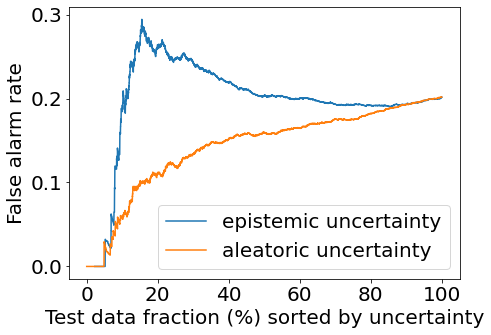

In [90]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_title("Prediction result")    
#for c in [cond0, cond1]:
_test_data_sorted = compute_cov_test(df_na_asos_BNN, col = "u_e", quan = "correct_pred",ascending = True)
a1 = ax.plot(
    _test_data_sorted["u_e_cov"],
    _test_data_sorted["cu_FAR"],label="epistemic uncertainty"
)
_test_data_sorted = compute_cov_test(df_na_asos_BNN, col = "u_a", quan = "correct_pred",ascending = True)
a2 = ax.plot(
    _test_data_sorted["u_a_cov"],
    _test_data_sorted["cu_FAR"],label="aleatoric uncertainty"
)
#ax.legend(bbox_to_anchor=(1.1, 1.05))#[a1,a2],["Sorted by epistemic uncertainty", "Sorted by aleatoric uncertainty")
ax.legend()
ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels([0,20,40,60,80,100])
ax.set_ylabel("False alarm rate")
ax.set_xlabel("Test data fraction (%) sorted by uncertainty")#Coverage (sorted by predicted epistemic uncertainty)")
#plt.legend(['CI'])
plt.show()

In [83]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

0        False
1         True
2         True
3         True
4         True
         ...  
13742     True
13743     True
13744     True
13745    False
13746     True
Length: 13747, dtype: bool

In [92]:
_test_data_sorted["u_a_cov"]

6225     0.000073
12278    0.000145
2528     0.000218
9583     0.000291
1375     0.000364
           ...   
8014     0.999709
3040     0.999782
12276    0.999855
2344     0.999927
10105    1.000000
Name: u_a_cov, Length: 13747, dtype: float64

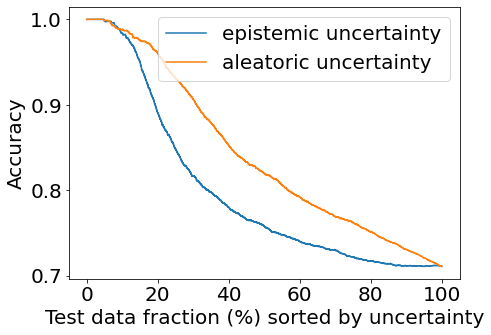

In [82]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_title("Prediction result")    
#for c in [cond0, cond1]:
_test_data_sorted = compute_cov(df_na_asos_BNN, col = "u_e", quan = "correct_pred",ascending = True)
a1 = ax.plot(
    _test_data_sorted["u_e_cov"],
    _test_data_sorted["cu_correct_pred"],label="epistemic uncertainty"
)
_test_data_sorted = compute_cov(df_na_asos_BNN, col = "u_a", quan = "correct_pred",ascending = True)
a2 = ax.plot(
    _test_data_sorted["u_a_cov"],
    _test_data_sorted["cu_correct_pred"],label="aleatoric uncertainty"
)
#ax.legend(bbox_to_anchor=(1.1, 1.05))#[a1,a2],["Sorted by epistemic uncertainty", "Sorted by aleatoric uncertainty")
ax.legend()
ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels([0,20,40,60,80,100])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Test data fraction (%) sorted by uncertainty")#Coverage (sorted by predicted epistemic uncertainty)")
#plt.legend(['CI'])
plt.show()

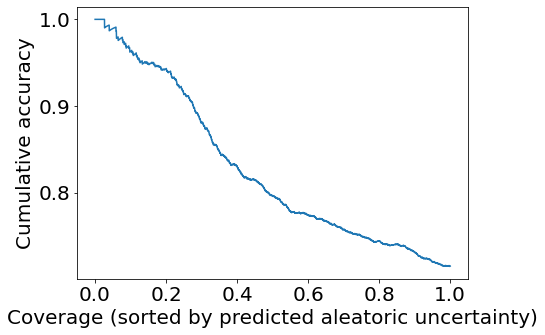

In [44]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_title("Prediction result")    
#for c in [cond0, cond1]:
_test_data_sorted = compute_cov(df_na_asos, col = "u_a", quan = "correct_pred",ascending = True)
ax.plot(
    _test_data_sorted["u_a_cov"],
    _test_data_sorted["cu_correct_pred"]
)
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted aleatoric uncertainty)")
#plt.legend(['CI'])
plt.show()

In [25]:
correct = ((df_na_asos["labels"]==1) & (df_na_asos["pred_conf"]>0.5)) | ((df_na_asos["labels"]==0) & (df_na_asos["pred_conf"]<0.5))
error = ((df_na_asos["labels"]==1) & (df_na_asos["pred_conf"]<0.5)) | ((df_na_asos["labels"]==0) & (df_na_asos["pred_conf"]>0.5))

In [61]:
np.sum((df_na_asos["labels"]==1) & (df_na_asos["pred_conf"]<0.5))

109

In [29]:
data = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 3]], 200)
print(np.shape(data.T))
print(np.shape((x,y)))

(2, 200)
(2, 2762)


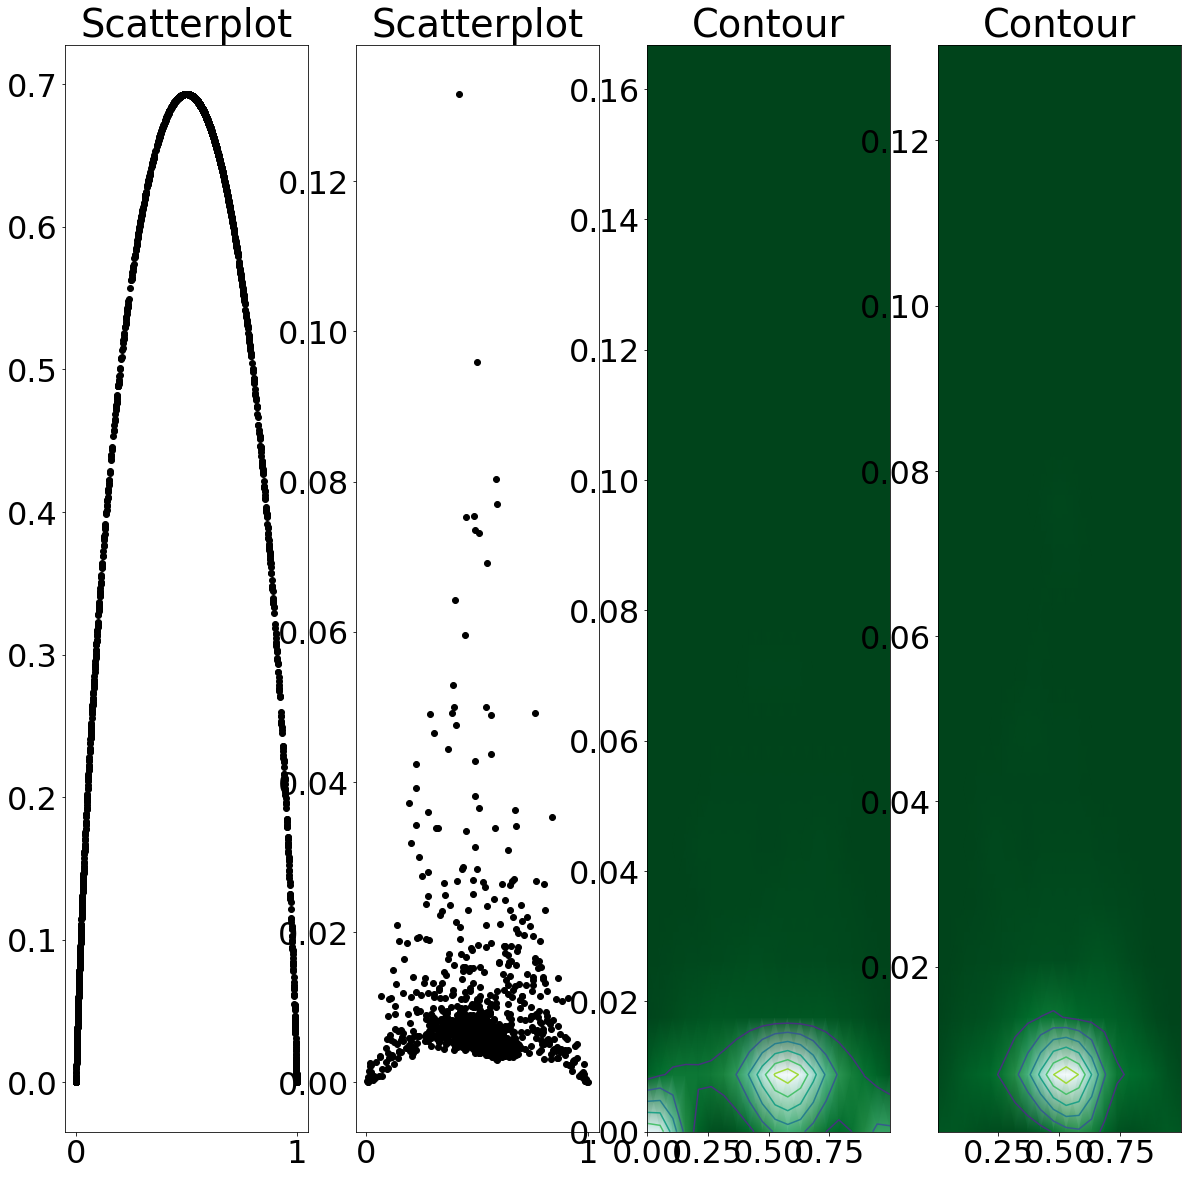

In [21]:
from scipy.stats import kde
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20, 20))

# Everything starts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].plot(df_na_asos["pred_conf"][correct], df_na_asos["u_t"][correct], 'ko')

axes[1].set_title('Scatterplot')
axes[1].plot(df_na_asos["pred_conf"][error], df_na_asos["var"][error], 'ko')

x = df_na_asos["pred_conf"][correct]
y = df_na_asos["var"][correct]
k = kde.gaussian_kde((x,y))
nbins = 20
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
axes[2].set_title('Contour')
axes[2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
correct_contour = axes[2].contour(xi, yi, zi.reshape(xi.shape) )
#fig.colorbar(correct_contour)

x = df_na_asos["pred_conf"][error]
y = df_na_asos["var"][error]
k = kde.gaussian_kde((x,y))
nbins = 20
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
axes[3].set_title('Contour')
axes[3].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
correct_contour = axes[3].contour(xi, yi, zi.reshape(xi.shape) )

In [99]:
zi.max()

719.3937926487337

Text(0.5, 0, 'P(CI)')

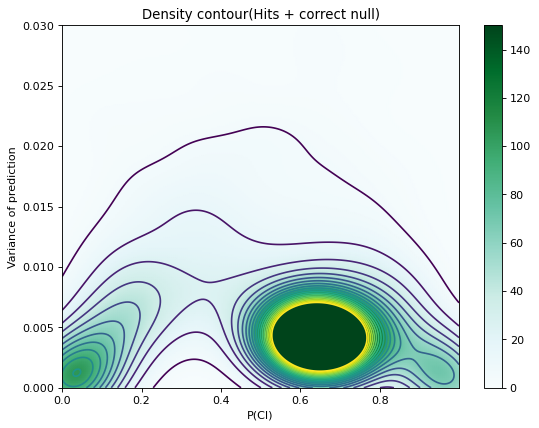

In [126]:
x = df_na_asos["pred_conf"][correct]
y = df_na_asos["var"][correct] #epistemic?
k = kde.gaussian_kde((x,y))
nbins = 200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():0.03:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Density contour(Hits + correct null)')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), vmin = 0, vmax = 150, shading='gouraud', cmap=plt.cm.BuGn)
plt.colorbar()
plt.contour(xi, yi, zi.reshape(xi.shape),levels=np.arange(5,200,10))
plt.ylabel("Variance of prediction")
plt.xlabel("P(CI)")         

Text(0.5, 0, 'P(CI)')

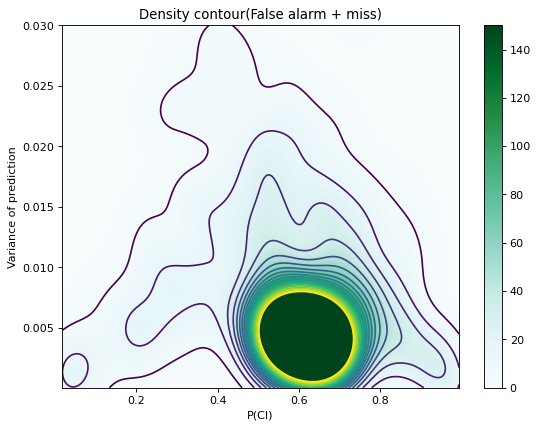

In [125]:
x = df_na_asos["pred_conf"][error]
y = df_na_asos["var"][error]
k = kde.gaussian_kde((x,y))
nbins = 200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():0.03:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Density contour(False alarm + miss)')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), vmin = 0, vmax = 150, shading='gouraud', cmap=plt.cm.BuGn)
plt.colorbar()
plt.contour(xi, yi, zi.reshape(xi.shape),levels=np.arange(5,200,10))
plt.ylabel("Variance of prediction")
plt.xlabel("P(CI)")         

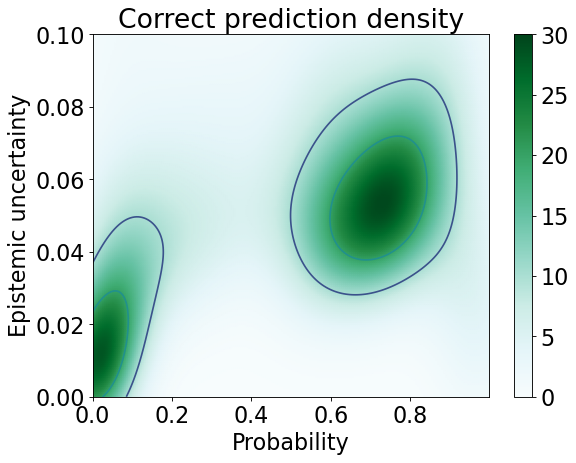

In [41]:
from scipy.stats import kde
plt.rcParams['font.size'] = '20'
x = df_na_asos["pred_conf"][correct]
y = df_na_asos["u_e"][correct] #epistemic?
k = kde.gaussian_kde((x,y))
nbins = 200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():0.1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Correct prediction density')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), vmin = 0, vmax = 30, shading='gouraud', cmap=plt.cm.BuGn)
plt.colorbar()
plt.contour(xi, yi, zi.reshape(xi.shape),levels=np.arange(0,50,10))
plt.ylabel("Epistemic uncertainty")
plt.xlabel("Probability")         
plt.savefig('plots/Correct_Epi.png')

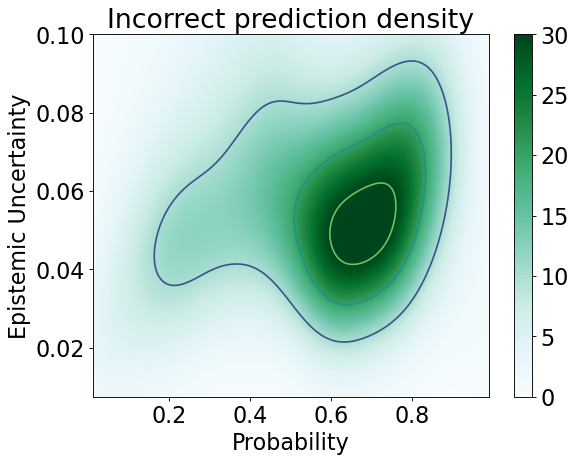

In [42]:
x = df_na_asos["pred_conf"][error]
y = df_na_asos["u_e"][error]
k = kde.gaussian_kde((x,y))
nbins = 200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():0.1:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Incorrect prediction density')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), vmin = 0, vmax = 30, shading='gouraud', cmap=plt.cm.BuGn)
plt.colorbar()
plt.contour(xi, yi, zi.reshape(xi.shape),levels=np.arange(0,50,10))
plt.ylabel("Epistemic Uncertainty")
plt.xlabel("Probability") 
plt.savefig('plots/Incorrect_Epi.png')

In [36]:
y.shape

(2705,)

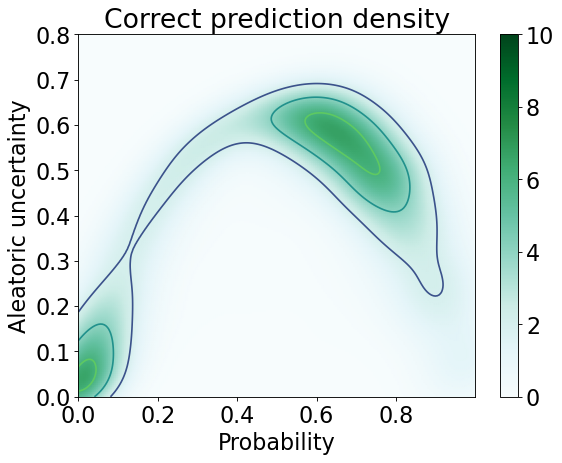

In [43]:
plt.rcParams['font.size'] = '20'
x = df_na_asos["pred_conf"][correct]
y = df_na_asos["u_a"][correct] #epistemic?
k = kde.gaussian_kde((x,y))
nbins = 200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():0.8:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Correct prediction density')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), vmin = 0, vmax = 10, shading='gouraud', cmap=plt.cm.BuGn)
plt.colorbar()
plt.contour(xi, yi, zi.reshape(xi.shape),levels=np.arange(0,10,2))
plt.ylabel("Aleatoric uncertainty")
plt.xlabel("Probability")
plt.savefig('plots/Correct_Alea.png')

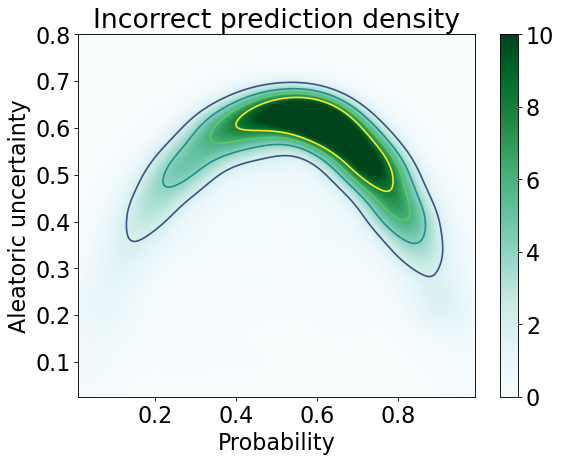

In [44]:
plt.rcParams['font.size'] = '20'
x = df_na_asos["pred_conf"][error]
y = df_na_asos["u_a"][error] #epistemic?
k = kde.gaussian_kde((x,y))
nbins = 200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():0.8:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Incorrect prediction density')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), vmin = 0, vmax = 10, shading='gouraud', cmap=plt.cm.BuGn)
plt.colorbar()
plt.contour(xi, yi, zi.reshape(xi.shape),levels=np.arange(0,10,2))
plt.ylabel("Aleatoric uncertainty")
plt.xlabel("Probability")   
plt.savefig('plots/Incorrect_Alea.png')

#### results_dict["mu"] = tf.concat(results_dict["mu"], 0)
    results_dict["var"] = tf.concat(results_dict["var"], 0)    
    results_dict["pred_probs"] = tf.concat(results_dict["pred_probs"], 0)

In [184]:
    results_dict["mu"] = results_dict["mu"][:, 1].cpu().numpy()
    results_dict["var"] = results_dict["var"][:, 1].cpu().numpy()    
    results_dict["pred_conf"] =  results_dict["pred_probs"][:,1].cpu().numpy()

In [185]:
df_na_asos=pd.DataFrame()
df_na_asos["pred_conf"] = results_dict["pred_probs"][:, 1].cpu().numpy()#np.max(results_dict["pred_probs"].cpu().numpy(), 1)
df_na_asos["mu"] = results_dict["mu"]
df_na_asos["var"] = results_dict["var"]
df_na_asos.to_parquet(f"./test10.parquet")

In [ ]:
u_a

In [ ]:
mu

In [ ]:
variance

In [114]:
mu = (( 2.5684795-1.5374303)/2)**2/2
mu

0.13288280660258

In [12]:
def calculate_uncertainty(MC_preds):
    def aleatoric(MC_log_vars):
        '''aleatoric uncertainty per datapoint'''
        # (N,)
        return np.mean(np.exp(MC_log_vars), axis=0).squeeze() # mean uncertainty of all MC sample log variances

    def epistemic(MC_logits):
        '''epistemic uncertainty per datapoint'''
        # (T, N, K)
        y_hat = np.mean(softmax(MC_logits), axis=0) # mean softmax of all MC sample logits
        y_hat = np.clip(y_hat, 1e-11, 1 - 1e-11) # prevent nans
        # (N,)
        return np.array([-np.sum(y_hat[i] * np.log(y_hat[i])) for i in range(y_hat.shape[0])])#, ndmin=2).T

    #n_classes = MC_preds.shape[-1] // 2 #10
    n_classes = MC_preds.shape[-1] -1 #10
    return aleatoric(MC_preds[...,n_classes:]), epistemic(MC_preds[...,:n_classes]) 

def softmax(logits):
    e = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    s = np.sum(e, axis=-1, keepdims=True)
    return e / s

In [32]:
from collections import defaultdict, OrderedDict
#seed_everything(4838)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled,test_label_one_hot))
data = dataset.batch(batch_size=564)
num_classes = 2
results_dict = defaultdict(list)
num_mc = 100 #100
for inputs, labels in data:
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    predict_prob = np.zeros((num_mc, len(labels), num_classes), dtype=np.float32)
    logit_var = np.zeros((num_mc, len(labels), num_classes+1), dtype=np.float32)
    for i in range(num_mc):
        outputs = model(inputs, training=True) #logit
        output = outputs[:,:2] #logit/mu
        #mu[i,:,:] = output #np.mean(output,axis=1)
        #var[i,:] = outputs[:,2] #variance
        #np.var(logit_MC, axis = 0)
        #logit_MC[i,:,:] = output#tf.expand_dims(output[:,1],-1)
        #mu = np.mean(output)
        #var = 
        evidence = K.relu(output)
        alpha = evidence + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)
        predict_prob[i,:,:] = prob#tf.expand_dims(prob[:,1],-1)
        logit_var[i,:,:] = outputs
    #var = np.var(logit_MC, axis = 0)
    #mu = np.mean(logit_MC, axis = 0)
    u_a, u_e = calculate_uncertainty(logit_var)
    #u_a = np.mean(var**2,axis=0)
    #u_e = np.sum(np.mean(mu**2,axis=0)-np.mean(mu,axis=0)**2,axis=1)
    #u_t = -1 * np.sum(entropy(np.mean(predict_prob, axis=0)), axis=1)
    #u_a = np.mean(-1 * np.sum(entropy(predict_prob), axis=2), axis=0)
    #u_e = u_t - u_a
    #results_dict["u_t"].append(tf.expand_dims(u_t,-1))    
    results_dict["u_a"].append(tf.expand_dims(u_a,-1))
    results_dict["u_e"].append(tf.expand_dims(u_e,-1))
    results_dict["pred_probs"].append(np.mean(predict_prob, axis=0))
    #break

In [ ]:
u_e

In [ ]:
u_a

In [42]:
from collections import defaultdict, OrderedDict
#seed_everything(4838)
predictions = []
uncertinties = []
probabilities= []
train_loss_results= []
val_acc = []
dataset = tf.data.Dataset.from_tensor_slices((test_data_scaled,test_label_one_hot))
data = dataset.batch(batch_size=564)
num_classes = 2
results_dict = defaultdict(list)
num_mc = 100 #100
for inputs, labels in data:
    #print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    predict_prob = np.zeros((num_mc, len(labels), num_classes-1), dtype=np.float32)
    logit_MC = np.zeros((num_mc, len(labels), num_classes), dtype=np.float32)
    for i in range(num_mc):
        output = model(inputs, training=True) #logit
        variance_pre = Dense(1)(x)
        variance = Activation('softplus', name='variance')(variance_pre)
        logit_MC[i,:,:] = output#tf.expand_dims(output[:,1],-1)
        #mu = np.mean(output)
        #var = 
        evidence = K.relu(output)
        alpha = evidence + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)
        predict_prob[i,:,:] = tf.expand_dims(prob[:,1],-1)
    #var = np.var(logit_MC, axis = 0)
    #mu = np.mean(logit_MC, axis = 0)
    u_t = -1 * np.sum(entropy(np.mean(predict_prob, axis=0)), axis=1)
    u_a = np.mean(-1 * np.sum(entropy(predict_prob), axis=2), axis=0)
    u_e = u_t - u_a
    results_dict["u_t"].append(tf.expand_dims(u_t,-1))    
    results_dict["u_a"].append(tf.expand_dims(u_a,-1))
    results_dict["u_e"].append(tf.expand_dims(u_e,-1))
    results_dict["pred_probs"].append(np.mean(predict_prob, axis=0))
    break
    '''
    preds = np.argmax(output, axis=-1)
    label = np.argmax(labels,axis=-1)
    acc = np.sum(preds==label)/len(preds)
    uncertainty = num_classes / S #K.sum(alpha, axis=1, keepdims=True)
    #prob = alpha / S #K.sum(alpha, axis=1, keepdims=True)
    err = K.sum(K.pow((labels-prob),2),axis=1,keepdims=True) #K.sum(K.pow((labels-prob),2),axis=0,keepdims=True)
    var = K.sum(alpha*(S-alpha)/(S*S*(S+1)),axis=1,keepdims=True)
    ua = -prob[:,1]*np.log2(prob[:,1])
    #print(err)
    #print(var)
    #break
    results_dict["uncertainty"].append(uncertainty)
    results_dict["ua"].append(tf.expand_dims(ua,-1))
    results_dict["pred_labels"].append(tf.expand_dims(preds,-1))
    results_dict["true_labels"].append(tf.expand_dims(label,-1))
    results_dict["pred_probs"].append(prob)
    results_dict["variance"].append(var)
    #results_dict["ev_error"].append(tf.expand_dims(err,-1))
    results_dict["ev_error"].append(err)
    print(acc)
    #val_acc.append(acc)
    #print("Epoch {:03d}: Loss: {:.3f}, val_acc:{:.3f}".format(epoch,epoch_loss_avg.result(),acc))
    '''
    
    '''
    evidence = K.relu(output)
    alpha = evidence + 1
    uncertainty = num_classes / K.sum(alpha, axis=1, keepdims=True)
    preds = np.argmax(output, axis=-1)
    label = np.argmax(labels, axis=-1)
    prob = alpha / K.sum(alpha, axis=1, keepdims=True)
    print(np.min(prob))
    print(np.max(prob))
        
    #print(prob.shape)
    results_dict["uncertainty"].append(uncertainty)
    results_dict["pred_labels"].append(tf.expand_dims(preds,-1))
    results_dict["true_labels"].append(tf.expand_dims(label,-1))
    results_dict["pred_probs"].append(tf.expand_dims(prob,-1))
    ''' 

In [43]:
output

<tf.Tensor: shape=(564, 2), dtype=float32, numpy=
array([[ 8.305411 ,  0.8799211],
       [ 7.65593  ,  3.0997224],
       [-8.437019 , 13.262059 ],
       ...,
       [ 6.9427257,  7.598046 ],
       [ 9.037845 ,  3.4433746],
       [ 9.294699 ,  4.300625 ]], dtype=float32)>

In [47]:
from tensorflow.keras import layers
variance_pre = layers.Dense(1)(output)
variance = layers.Activation('softplus', name='variance')(variance_pre)

In [23]:
    results_dict["pred_conf"] =  np.max(results_dict["pred_probs"].cpu().numpy(), 1)

AttributeError: 'list' object has no attribute 'cpu'

In [82]:
    #results_dict["u_t"] = tf.concat(results_dict["u_t"], 0)
    results_dict["u_a"] = tf.concat(results_dict["u_a"], 0)
    results_dict["u_e"] = tf.concat(results_dict["u_e"], 0)    
    results_dict["pred_probs"] = tf.concat(results_dict["pred_probs"], 0)

In [83]:
    #results_dict["u_t"] = results_dict["u_t"][:, 0].cpu().numpy()
    results_dict["u_a"] = results_dict["u_a"][:, 0].cpu().numpy()
    results_dict["u_e"] = results_dict["u_e"][:, 0].cpu().numpy()    
    results_dict["pred_conf"] =  np.max(results_dict["pred_probs"].cpu().numpy(), 1)

In [84]:
df_na_asos=pd.DataFrame()
df_na_asos["pred_conf"] = results_dict["pred_probs"][:, 0].cpu().numpy()#np.max(results_dict["pred_probs"].cpu().numpy(), 1)
df_na_asos["u_a"] = results_dict["u_a"]
df_na_asos["u_e"] = results_dict["u_e"]
#df_na_asos["u_t"] = results_dict["u_t"]

In [ ]:
uncertainty.shape

In [ ]:
tf.expand_dims(ua,-1).shape

In [ ]:
ua = -prob[:,1]*np.log2(prob[:,1])#-prob[:,0]*np.log(prob[:,0])
#ut = -
#ua = K.sum(-prob[:,1]*np.log2(prob[:,1]), axis=1, keepdims=True)
print(ua)

In [ ]:
    results_dict["uncertainty"] = tf.concat(results_dict["uncertainty"], 0)
    results_dict["ua"] = tf.concat(results_dict["ua"], 0)    
    results_dict["pred_probs"] = tf.concat(results_dict["pred_probs"], 0)
    results_dict["variance"] = tf.concat(results_dict["variance"], 0)
    results_dict["ev_error"] = tf.concat(results_dict["ev_error"], 0)
    results_dict["pred_labels"] = tf.concat(results_dict["pred_labels"], 0)
    results_dict["true_labels"] = tf.concat(results_dict["true_labels"], 0)

In [ ]:
results_dict["uncertainty"].shape

In [ ]:
    results_dict["uncertainty"] = results_dict["uncertainty"][:, 0].cpu().numpy()
    results_dict["ua"] = results_dict["ua"][:, 0].cpu().numpy()    
    results_dict["variance"] = results_dict["variance"][:, 0].cpu().numpy()
    results_dict["ev_error"] = results_dict["ev_error"][:, 0].cpu().numpy()
    results_dict["pred_conf"] =  np.max(results_dict["pred_probs"].cpu().numpy(), 1) #results_dict["pred_probs"].cpu().numpy() #np.max(results_dict["pred_probs"].cpu().numpy(), 1) #results_dict["pred_probs"][:,1].cpu().numpy() #np.max(results_dict["pred_probs"].cpu().numpy(), 1)
    results_dict["pred_labels"] = results_dict["pred_labels"][:, 0].cpu().numpy()
    results_dict["true_labels"] = results_dict["true_labels"][:, 0].cpu().numpy()#np.max(results_dict["true_labels"].cpu().numpy(), 1)

In [ ]:
outputs = ["no-CI","CI"]
df_na_asos=pd.DataFrame()
df_na_asos["lat"]=lat_0
df_na_asos["lon"]=lon_0
for idx in range(len(outputs)):
    df_na_asos[f"{outputs[idx]}_conf"] = results_dict["pred_probs"][:, idx].cpu().numpy()
df_na_asos["uncertainty"] = results_dict["uncertainty"]
df_na_asos["pred_labels"] = results_dict["pred_labels"]
df_na_asos["true_labels"] = results_dict["true_labels"]
df_na_asos["pred_conf"] = np.max(results_dict["pred_probs"].cpu().numpy(), 1)

In [ ]:
df_na_asos

In [ ]:
import glob
from cartopy import crs as ccrs
from cartopy import feature as cfeature
latN = 49.0
latS = 33.0
lonW = -90.0
lonE = -105.0
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2
colors = {0:'dodgerblue', 1:'red'}#, 2:'red', 3:'black'}

In [ ]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(2):
    ax.scatter(df_na_asos["lon"][df_na_asos["true_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["true_labels"] == i],
               c=df_na_asos["true_labels"][df_na_asos["true_labels"] == i].map(colors),
               s=20, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI observations, Great Plain 6/27-6/30/2020", fontsize=20)

In [ ]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(18, 12))
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.set_extent([lonW, lonE, latS, latN])
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.add_feature(cfeature.LAND.with_scale(res))
ax1.add_feature(cfeature.OCEAN.with_scale(res))
ax1.add_feature(cfeature.COASTLINE.with_scale(res))
ax1.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax1.add_feature(cfeature.STATES.with_scale(res))

for i in range(2):
    ax1.scatter(df_na_asos["lon"][df_na_asos["pred_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["pred_labels"] == i],
               c=df_na_asos["pred_labels"][df_na_asos["pred_labels"] == i].map(colors),
               s=20, transform=ccrs.PlateCarree())

plt.legend(colors.values(), labels=["no-CI", "CI"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI predictions, Great Plain 6/27-6/30/2020", fontsize=20)

In [ ]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(24, 18))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(2):
    sc = ax.scatter(df_na_asos["lon"][df_na_asos["pred_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["pred_labels"] == i],
               c=df_na_asos["pred_conf"][df_na_asos["pred_labels"] == i],
               s=20, transform=ccrs.PlateCarree(), cmap='Greys', 
               vmin=df_na_asos["pred_conf"].min(), vmax=df_na_asos["pred_conf"].max())

cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label('Confidence',size=12)
plt.title("CI/no-CI confidence, Great Plain 6/27-6/30/2020", fontsize=20)

In [ ]:
print(ax)

In [ ]:
print(df_na_asos["lon"][df_na_asos["pred_labels"] == i]-360)

In [ ]:
proj = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
res = '50m'  # Coarsest and quickest to display; other options are '10m' (slowest) and '50m'.
fig = plt.figure(figsize=(24, 18))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent([lonW, lonE, latS, latN],crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND.with_scale(res))
ax.add_feature(cfeature.OCEAN.with_scale(res))
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.LAKES.with_scale(res), alpha=0.5)
ax.add_feature(cfeature.STATES.with_scale(res))

for i in range(2):
    sc = ax.scatter(df_na_asos["lon"][df_na_asos["pred_labels"] == i]-360,
               df_na_asos["lat"][df_na_asos["pred_labels"] == i],
               c=df_na_asos["uncertainty"][df_na_asos["pred_labels"] == i],
               s=20, transform=ccrs.PlateCarree(), cmap='Greys', 
               vmin=df_na_asos["uncertainty"].min(), vmax=df_na_asos["uncertainty"].max())
#ax.set_xlim(lonE,lonW)
#ax.set_xticks(np.arange(lonE,lonW))
#ax.set_yticks(np.arange(latS,latN))
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.1)
cbar.set_label('Uncertainty',size=18)
#plt.legend(colors.values(), labels=["Rain", "Snow", "Ice Pellets", "Freezing Rain"], fontsize=24, markerscale=3, loc="lower right")
plt.title("CI/no-CI uncertainty, Great Plain 6/27-6/30/2020", fontsize=20)
plt.show()

In [ ]:
    results_dict["noCI_pred_conf"] =  results_dict["pred_probs"][:,0].cpu().numpy()
    results_dict["CI_pred_conf"] =  results_dict["pred_probs"][:,1].cpu().numpy()

In [ ]:
df = pd.DataFrame()
df["uncertainty"] = results_dict["uncertainty"]
df["ua"] = results_dict["ua"]
df["pred_labels"] = results_dict["pred_labels"]
df["true_labels"] = results_dict["true_labels"]
df["pred_conf"] = results_dict["pred_conf"]#results_dict["CI_pred_conf"]#results_dict["CI_pred_conf"]#results_dict["CI_pred_conf"]#results_dict["CI_pred_conf"]#results_dict["pred_conf"]
df["ev_error"] = results_dict["ev_error"]
df["variance"] = results_dict["variance"] 
#df.to_parquet(f"{save_loc}/{name}.parquet")
df.to_parquet(f"./test.parquet")

In [ ]:
#Rescale?
from application.reliability import reliability_diagram, reliability_diagrams, compute_calibration
title = "CI EDL"
fig = reliability_diagram(
    results_dict["true_labels"],#.numpy(), 
    results_dict["pred_labels"],#.numpy(), 
    results_dict["pred_conf"],#.numpy(), 
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100, 
    return_fig=True)

In [ ]:
from application.reliability import reliability_diagram, reliability_diagrams, compute_calibration
title = "EDL(CI class)"
fig = reliability_diagram(
    results_dict["true_labels"],#.numpy(), 
    results_dict["pred_labels"],#.numpy(), 
    results_dict["CI_pred_conf"],#.numpy(), 
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100, 
    return_fig=True)

In [ ]:
from application.reliability import reliability_diagram, reliability_diagrams, compute_calibration
title = "EDL(no-CI class)"
fig = reliability_diagram(
    results_dict["true_labels"],#.numpy(), 
    results_dict["pred_labels"],#.numpy(), 
    results_dict["noCI_pred_conf"],#.numpy(), 
    num_bins=10, draw_ece=True,
    draw_bin_importance="alpha", draw_averages=True,
    title=title, figsize=(5, 5), dpi=100, 
    return_fig=True)

In [ ]:
cond0 = (results_dict["true_labels"] == 0)
cond1 = (results_dict["true_labels"] == 1)

results = OrderedDict()
results['no_CI'] = {
    "true_labels": results_dict["true_labels"][cond0], 
    "pred_labels": results_dict["pred_labels"][cond0], 
    "confidences": results_dict["pred_conf"][cond0]
}
results['CI'] = {
    "true_labels": results_dict["true_labels"][cond1], 
    "pred_labels": results_dict["pred_labels"][cond1], 
    "confidences": results_dict["pred_conf"][cond1]
}
results['123'] = {
    "true_labels": results_dict["true_labels"][cond0], 
    "pred_labels": results_dict["pred_labels"][cond0], 
    "confidences": results_dict["pred_conf"][cond0]
}
results['456'] = {
    "true_labels": results_dict["true_labels"][cond1], 
    "pred_labels": results_dict["pred_labels"][cond1], 
    "confidences": results_dict["pred_conf"][cond1]
}

In [ ]:
results['CI'] 

In [ ]:
for i, (plot_name, data) in enumerate(results.items()):
    print(plot_name)

In [ ]:
print(results)

In [ ]:
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=2, dpi=100, return_fig=True)

In [ ]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

In [ ]:
test_data = pd.read_parquet(f"./test.parquet")
test_data["acc"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()
test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "acc")

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}
import matplotlib
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Bulk result")

ax.plot(
    test_data_sorted["pred_conf_cov"],
    test_data_sorted["cu_acc"]
)
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Class result")    
for c in [cond0, cond1]:
    _test_data_sorted = compute_cov(test_data[c], col = "pred_conf", quan = "acc")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_acc"]
    )
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.legend(['no-CI','CI'])
plt.show()

In [ ]:
max(df["uncertainty"])

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

test_data_sorted = compute_cov(test_data, col = "uncertainty", quan = "acc", ascending = True)

l1, = ax.plot(
    test_data_sorted["uncertainty"],
    test_data_sorted["cu_acc"],
    label = "sigma"
)

ax2 = ax.twiny()
l2, = ax2.plot(
    test_data_sorted["uncertainty_cov"],
    test_data_sorted["cu_acc"], 
    color='orange', ls = "--", 
    label = "fraction")

ax.set_ylabel("Cumulative accuracy")
ax2.set_xlabel("Test data fraction")
ax.set_xlabel("Predicted uncertainty")

plt.legend([l1, l2], ["sigma", "fraction"])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='col')

for c in [cond0, cond1]:
    _test_data_sorted = compute_cov(test_data[c], col = "uncertainty", quan = "acc", ascending = True)
    ax[0].plot(
        _test_data_sorted["uncertainty"],
        _test_data_sorted["cu_acc"]
    )
    plt.legend(['no-CI','CI'])
    _test_data_sorted = compute_cov(test_data[c], col = "uncertainty", quan = "acc", ascending = True)
    ax[1].plot(
        _test_data_sorted["uncertainty_cov"],
        _test_data_sorted["cu_acc"],
        ls = "--"
    )
    
ax[0].set_ylabel("Cumulative accuracy")
#ax[0].set_xlabel("Coverage (sorted by predicted uncertainty)")
plt.legend(['no-CI','CI'])

ax[1].set_xlabel("Test data fraction")
ax[0].set_xlabel("Predicted uncertainty")


plt.show()

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
for c in [cond0, cond1]:
    _test_data_sorted = compute_cov(test_data[c], col = "uncertainty", quan = "acc", ascending = True)
    ax.plot(
        _test_data_sorted["uncertainty"],
        _test_data_sorted["cu_acc"]
    )
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted uncertainty)")
plt.show()

### For regression model
Aleatoric_uncertainty = np.mean(std_preds[i]**2)
Epistemic_uncertainty = np.mean(mu_preds[i]**2)-np.mean(mu_preds[i])**2

### For classification model
#Softmax entropy
def entropy_softmax(pred):
    class_num = pred.shape[1]
    prob = softmax(pred)
    entropy = - prob * (np.log(prob) / np.log(class_num))
    total_un = np.sum(entropy, axis=1, keepdims=True)
    class_un = entropy
    return total_un, class_un

In [19]:
def compute_cov_new(df, col = "var", quan = "error"):
    df = df.copy()
    df = df.sort_values(col, ascending = True)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

In [190]:
test_data["mu"]

0       0.806138
1       0.272834
2       0.660005
3       0.961489
4       0.596748
          ...   
3776    0.081602
3777    0.068842
3778    0.946390
3779    0.870885
3780    0.927567
Name: mu, Length: 3781, dtype: float32

In [82]:
df = pd.DataFrame()
#df["uncertainty"] = results_dict["uncertainty"]
mu_all = np.zeros((3781,10))
var_all = np.zeros((3781,10))
conf_all = np.zeros((3781,10))
for i in range(1,11):
    test_data = pd.read_parquet(f"./test"+str(i)+".parquet")
    mu_all[:,i-1]=test_data["mu"]
    var_all[:,i-1]=test_data["var"]
    conf_all[:,i-1]=test_data["pred_conf"]
    #test_data
#    test_data["acc"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()
#    test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "acc")

In [195]:
var_all_mean

array([0.00617421, 0.00578319, 0.00952247, ..., 0.00743191, 0.00479666,
       0.00581283])

In [193]:
mu_all_var = np.var(mu_all,axis=1)
var_all_mean = np.mean(var_all,axis=1)
pred_mean = np.mean(conf_all,axis = 1)

In [196]:
df["u_e"]=mu_all_var
df["u_a"]=var_all_mean
df["pred_conf"]=pred_mean

In [54]:
ue_MC = compute_cov_new(df_na_asos, col = "pred_conf", quan = "u_e")
ua_MC = compute_cov_new(df_na_asos, col = "pred_conf", quan = "u_a")

In [67]:
ue_RS = compute_cov_new(df_na_asos, col = "pred_conf", quan = "u_e")
ua_RS = compute_cov_new(df_na_asos, col = "pred_conf", quan = "u_a")

In [21]:
ue = compute_cov_new(df_na_asos, col = "pred_conf", quan = "u_e")
ua = compute_cov_new(df_na_asos, col = "pred_conf", quan = "u_a")
#ut = compute_cov_new(df_na_asos, col = "pred_conf", quan = "u_t")#,ascending = True)df_na_asos["u_e"]

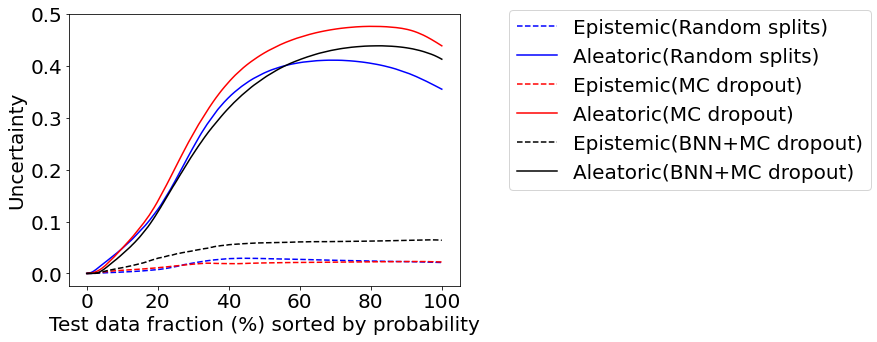

In [93]:
plt.rcParams['font.size'] = '20'
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
#ax.set_title("BNN + MC dropout")
ax.plot(ue_RS["pred_conf_cov"], ue_RS["cu_u_e"], 'b--')
ax.plot(ua_RS["pred_conf_cov"], ua_RS["cu_u_a"], 'b')
ax.plot(ue_MC["pred_conf_cov"], ue_MC["cu_u_e"], 'r--')
ax.plot(ua_MC["pred_conf_cov"], ua_MC["cu_u_a"], 'r')
ax.plot(ue["pred_conf_cov"], ue["cu_u_e"], 'k--')
ax.plot(ua["pred_conf_cov"], ua["cu_u_a"], 'k')
#ax.plot(ut["pred_conf_cov"], ut["cu_u_t"], color = 'k')
#ax.plot(ev_variance["variance_cov"], ev_variance["cu_ev_error"], zorder = 2, color = 'b')
#ax.plot(ev_evidence["pred_conf_cov"], ev_evidence["cu_ev_error"], zorder = 2, color = 'g')
ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_xticklabels([0,20,40,60,80,100])
ax.set_xlabel("Test data fraction (%) sorted by probability")
ax.set_ylabel("Uncertainty")
#ax.set_ylabel("MAE")

# Mean squared error 
#ax.set_xlim([0.0, 0.4])
#ax.set_ylim([0.0, 0.05])

ax.legend(["Epistemic(Random splits)", "Aleatoric(Random splits)","Epistemic(MC dropout)", "Aleatoric(MC dropout)","Epistemic(BNN+MC dropout)", "Aleatoric(BNN+MC dropout)"],bbox_to_anchor=(1.1, 1.05))

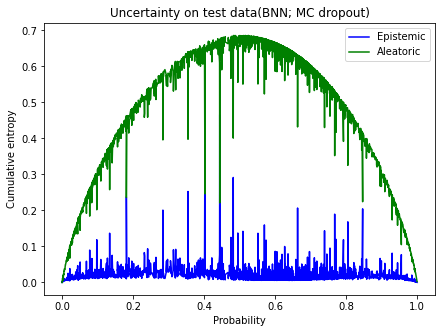

In [67]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Uncertainty on test data(BNN; MC dropout)")
ax.plot(ue["pred_conf"], ue["cu_u_e"], color = 'b')
ax.plot(ua["pred_conf"], ua["cu_u_a"], color = 'g')
#ax.plot(ut["pred_conf_cov"], ut["cu_u_t"], color = 'k')
#ax.plot(ev_variance["variance_cov"], ev_variance["cu_ev_error"], zorder = 2, color = 'b')
#ax.plot(ev_evidence["pred_conf_cov"], ev_evidence["cu_ev_error"], zorder = 2, color = 'g')
ax.set_xlabel("Probability")
ax.set_ylabel("Cumulative entropy")

# Mean squared error 
#ax.set_xlim([0.0, 0.4])
#ax.set_ylim([0.0, 0.05])

ax.legend(["Epistemic", "Aleatoric","Total"])

In [ ]:
#Plot epistemic and aleatoric uncertainty
ev_variance = compute_cov_new(df, col = "variance", quan = "ev_error")#,ascending = True)
ev_evidence = compute_cov_new(df, col = "pred_conf", quan = "ev_error")#,ascending = True)
#mlp_data_std = compute_cov(mlp_data, col = "mlp_pred_std", quan = "mlp_pred_error")
#mlp_model_std = compute_cov(mlp_model, col = "mlp_pred_std", quan = "mlp_pred_error")

In [ ]:
ev_variance["cu_ev_error"]

In [ ]:
ev_variance["variance_cov"]

In [ ]:
df["pred_conf"].shape

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Uncertainty on test data")
ax.plot(df["pred_conf"], df["uncertainty"], color = 'b')
ax.plot(df["pred_conf"], df["ua"], color = 'g')
#ax.plot(ev_variance["variance_cov"], ev_variance["cu_ev_error"], zorder = 2, color = 'b')
#ax.plot(ev_evidence["pred_conf_cov"], ev_evidence["cu_ev_error"], zorder = 2, color = 'g')
ax.set_xlabel("Confidence percentile")
ax.set_ylabel("MAE")

# Mean squared error 
#ax.set_xlim([0.0, 0.4])
#ax.set_ylim([0.0, 0.05])

ax.legend(["Epistemic", "Aleatoric"])

In [ ]:
results_dict["pred_labels"][cond0]

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(0.0005880438473553073),
    loss=loss_func_CE,
    metrics=["AUC"],
)

In [ ]:
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
K.set_floatx("float32")

In [ ]:
import random
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

In [ ]:
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)
K.set_floatx("float32")
class_weights = {0: 1.0, 1: 2.0}
seed_everything(4835)
with tf.device("/device:GPU:0"):
    model.fit(train_data_scaled, train_label_one_hot, batch_size=564, epochs=100, verbose=0,
                       validation_data=(test_data_scaled, test_label_one_hot), callbacks=[TimeHistory(), LossHistory(), EarlyStopping(monitor='val_loss',patience=10), ReduceLROnPlateau(monitor='val_loss',patience=3)],class_weight=class_weights)

In [ ]:
def var(name, shape, init=None):
    init = tf.compat.v1.truncated_normal_initializer(stddev=(1 / shape[0]) ** 0.5) if init is None else init
    return tf.compat.v1.get_variable(name=name, shape=shape, dtype=tf.float32, initializer=init)
var('W3', [10, 1000])

In [ ]:
print(TimeHistory().epoch_step)

In [ ]:
import sys
import os
#dir_path = os.path.dirname(os.path.realpath(__file__))
#sys.path.extend([dir_path])
import yaml
import tensorflow as tf
import pandas as pd
import numpy as np
from os.path import exists, join
from goes16ci.data import load_data_serial
from goes16ci.models import train_conv_net_cpu, train_conv_net_gpu, MinMaxScaler2D
from goes16ci.monitor import Monitor, start_timing, end_timing, get_gpu_names, get_gpu_topo, get_cuda_version, get_cudnn_version, get_nccl_version
import argparse
import logging
from datetime import datetime
import platform
from multiprocessing import Pipe, Process
import traceback
#from aimlutils.hyper_opt.base_objective import *
import optuna

In [ ]:
def main():
    config_file = open('/glade/work/fanda/optimization/benchmark_config_default.yml',"r")
    config = yaml.load(config_file, Loader=yaml.Loader)
    benchmark_data = dict()
    # load data serial
    benchmark_data["config"] = config
    benchmark_data["system"] = dict()
    benchmark_data["system"]["hostname"] = platform.node()
    benchmark_data["system"]["platform"] = platform.platform()
    benchmark_data["system"]["python_version"] = platform.python_version()
    benchmark_data["system"]["python_compiler"] = platform.python_compiler()
    benchmark_data["system"]["tensorflow_version"] = tf.__version__
    benchmark_data["system"]["gpus"] = get_gpu_names()
    has_gpus = True
    if len(benchmark_data["system"]["gpus"]) == 0:
        has_gpus = False
    #benchmark_data["system"].update(**get_cuda_version())
    benchmark_data["system"]["cudnn_version"] = get_cudnn_version()
    benchmark_data["system"]["nccl_version"] = get_nccl_version()
    benchmark_data["system"]["gpu_topology"] = get_gpu_topo()
    has_gpus = True #True
    out_path = '/glade/work/fanda/optimization'
    #print("Training Data==",train_data)
    parent_p, child_p = Pipe()
    dl_monitor = Monitor(child_p)
    monitor_proc = Process(target=dl_monitor.run)
    monitor_proc.start()
    batch_loss = None
    epoch_loss = None
    trial = None
    try:
        # CPU training
        if config["cpu"]:
            logging.info("CPU Training")
            block_name = "cpu_training"
            start_timing(benchmark_data, block_name, parent_p, out_path)
            epoch_times, batch_loss, epoch_loss = train_conv_net_cpu(train_data_scaled, train_label,
                            test_data_scaled, test_label, config["conv_net_parameters"],
                                             config["num_cpus"], config["random_seed"],trial=trial)
            end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
            benchmark_data[block_name]["batch_loss"] = batch_loss
            benchmark_data[block_name]["epoch_loss"] = epoch_loss

        # CPU inference

        # Multi GPU Training
        if config["multi_gpu"] and has_gpus:
            gpu_nums = np.array([2, 4, 8])
            gpu_nums = gpu_nums[gpu_nums <= np.minimum(config["num_gpus"], len(benchmark_data["system"]["gpus"]))]
            for gpu_num in gpu_nums:
                block_name = "gpu_{0:02d}_training".format(gpu_num)
                logging.info("Multi GPU Training {0:02d}".format(gpu_num))
                start_timing(benchmark_data, block_name, parent_p, out_path)
                epoch_times, batch_loss, epoch_loss = train_conv_net_gpu(train_data_scaled, train_counts,
                                                 val_data_scaled, val_counts, config["conv_net_parameters"],
                                                 gpu_num, config["random_seed"], dtype=config["dtype"], scale_batch_size=scale_batch_size,trial=trial)
                end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
                benchmark_data[block_name]["batch_loss"] = batch_loss
                benchmark_data[block_name]["epoch_loss"] = epoch_loss

        # Single GPU Training
        if config["single_gpu"] and has_gpus:
            print('yes')
            train_label_one_hot = tf.one_hot(train_label, 2).numpy()
            test_label_one_hot = tf.one_hot(test_label, 2).numpy()
            #scio.savemat('test_lead10_allIR_EDL.mat',{'test_data_scaled':test_data_scaled,'test_label':test_label_one_hot})
            logging.info("Single GPU Training")
            block_name = "gpu_{0:02d}_training".format(1)
            start_timing(benchmark_data, block_name, parent_p, out_path)
            epoch_times, batch_loss, epoch_loss = train_conv_net_gpu(train_data_scaled, train_label_one_hot,
                            test_data_scaled, test_label_one_hot, config["conv_net_parameters"],
                            1, config["random_seed"], dtype=config["dtype"], trial=trial)#,monitor='val_loss')
            end_timing(benchmark_data, epoch_times, block_name, parent_p, out_path)
            benchmark_data[block_name]["batch_loss"] = batch_loss
            benchmark_data[block_name]["epoch_loss"] = epoch_loss

        # Save benchmark data
        parent_p.send("exit")
        monitor_proc.join()
        output_filename = str(join(config["out_path"], "goes_benchmark_data_{0}.yml".format(datetime.utcnow().strftime("%Y%m%d_%H%M%S"))))
        logging.info("Saving benchmark data to {output_filename}".format(output_filename=output_filename))
        with open(output_filename, "w") as output_file:
            yaml.dump(benchmark_data, output_file,Dumper=yaml.Dumper)
        print_summary(benchmark_data)
    except Exception as e:
        logging.error(traceback.format_exc())
        parent_p.send("exit")
        monitor_proc.join()
        sys.exit()

def print_summary(benchmark_data):
    logging.info("*** GOES Summary ***")
    if "cpu_training" in benchmark_data.keys():
        logging.info("CPU Training")
        logging.info("Elapsed: {0:0.2f}".format(benchmark_data["cpu_training"]["elapsed_duration"]))
        logging.info("Epoch: {0:0.2f}".format(benchmark_data["cpu_training"]["epoch_duration"]))
        logging.info("Epoch/Elapsed: {0:0.3f}".format(benchmark_data["cpu_training"]["epoch_duration"]
                                                      / benchmark_data["cpu_training"]["elapsed_duration"]))
        logging.info("\n")
    for gpu in [1, 2, 4, 8]:
        block_name = "gpu_{0:02d}_training".format(gpu)
        if block_name in benchmark_data.keys():
            logging.info("{0:02d} GPU Training".format(gpu))
            logging.info("Elapsed: {0:0.2f}".format(benchmark_data[block_name]["elapsed_duration"]))
            logging.info("Epoch: {0:0.2f}".format(benchmark_data[block_name]["epoch_duration"]))
            logging.info("Epoch/Elapsed: {0:0.3f}".format(benchmark_data[block_name]["epoch_duration"]
                                                          / benchmark_data[block_name]["elapsed_duration"]))
            logging.info("\n")

    return
    
if __name__ == "__main__":
    main()

In [ ]:
test_label_one_hot = tf.one_hot(test_label, 2).numpy()
print(test_label_one_hot.shape)

In [ ]:
loss="CE"
print(loss)
if loss is "CE":
    loss = 123
    print(loss)

In [ ]:
print(my_model.input)

In [ ]:
import scipy.io as scio
scio.savemat('test_lead10_allIR_EDL.mat',{'test_data_scaled':test_data_scaled,'test_label':test_label_one_hot})

In [ ]:
print(my_model.summary())

In [ ]:
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
resNet_mod = ResNet(epochs=30, batch_size=512, loss='binary_crossentropy', pooling= 'mean', metrics='AUC', use_dropout='True',dropout_alpha=0.2,)
vars(resNet_mod)

In [ ]:
resNet_mod.fit(train_data_scaled, train_label, test_data_scaled, test_label)
resNet_mod.model.summary()

In [ ]:
AUC
GOES-only: 0.54
GPM-only: 0.77
HRRR-only: 0.



In [ ]:
import pandas as pd
val_his = pd.read_csv("AUC_history.csv")
val_his.head()

In [ ]:
import pandas as pd
val_his = pd.read_csv("AUC_history.csv")
AUC = val_his.iloc[1,:]
val_auc = val_his.iloc[4,:]
Train_AUC = []
Val_ACU = []
for i in AUC[1:]:
    temp = str(i).strip('[').strip(']')
    Train_AUC.append(float(temp))
for i in val_auc[1:]:
    temp = str(i).strip('[').strip(']')
    Val_ACU.append(float(temp))


In [ ]:
import matplotlib.pyplot as plt
Elapsed_time1 = 653.7025706768036
Elapsed_time4 = 181.0528860092163
epoch=np.arange(1,np.size(Train_AUC)+1)
#val_mean_squared_error_1cpu=val_his[]
#val_mean_squared_error_4cpu=[0.44336193799972534, 0.4488404095172882, 0.5589040517807007, 0.6212853789329529, 0.6652269959449768, 0.6774303317070007, 0.6933239102363586, 0.6977429986000061, 0.7127474546432495, 0.7368190288543701, 0.7493003606796265, 0.7608986496925354, 0.7678315043449402, 0.7697786688804626, 0.7710341215133667, 0.7769752144813538, 0.781409740447998, 0.7737517952919006, 0.7870616316795349, 0.7729336023330688]
plt.plot(epoch, Train_AUC)
plt.plot(epoch, Val_ACU)
plt.legend(['Train AUC','Val AUC'])
plt.xticks(np.arange(0, 40, step=5))
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

In [ ]:
max(Val_ACU)

In [ ]:
import matplotlib.pyplot as plt
Elapsed_time1 = 653.7025706768036
Elapsed_time4 = 181.0528860092163
epoch=np.arange(1,np.size(Train_AUC)+1)
#val_mean_squared_error_1cpu=val_his[]
#val_mean_squared_error_4cpu=[0.44336193799972534, 0.4488404095172882, 0.5589040517807007, 0.6212853789329529, 0.6652269959449768, 0.6774303317070007, 0.6933239102363586, 0.6977429986000061, 0.7127474546432495, 0.7368190288543701, 0.7493003606796265, 0.7608986496925354, 0.7678315043449402, 0.7697786688804626, 0.7710341215133667, 0.7769752144813538, 0.781409740447998, 0.7737517952919006, 0.7870616316795349, 0.7729336023330688]
plt.plot(epoch, Train_AUC)
plt.plot(epoch, Val_ACU)
plt.legend(['Train AUC','Val AUC'])
plt.xticks(np.arange(0, 100, step=5))
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
Elapsed_time1 = 653.7025706768036
Elapsed_time4 = 181.0528860092163
epoch=np.arange(1,16)
val_mean_squared_error_1cpu=[0.24762912094593048, 0.25116780400276184, 0.24518859386444092, 0.24795278906822205, 0.2455170750617981, 0.24410925805568695,\
                        0.2457471787929535, 0.2435547560453415, 0.24430130422115326, 0.24315588176250458, 0.24411983788013458, 0.24301357567310333, \
                        0.24307729303836823, 0.24286054074764252, 0.2423982322216034]
val_mean_squared_error_4cpu=[0.24558548629283905, 0.24892574548721313, 0.24420025944709778, 0.2463153898715973, 0.24364298582077026, 0.2437734305858612,\
                             0.24374336004257202, 0.24291828274726868, 0.24398469924926758, 0.24342210590839386, 0.24224412441253662, 0.2430204451084137, \
                             0.2419077605009079, 0.24149034917354584, 0.24141058325767517]
plt.plot(epoch, val_mean_squared_error_1cpu)
plt.plot(epoch, val_mean_squared_error_4cpu)
plt.legend(['ncpu=1','ncpu=4'])
plt.xticks(np.arange(0, 15, step=5))
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.show()